<h3 align="center"><b>End‑to‑end Churn Prediction System<br> with Agent Collaboration</b></h3>
<hr style="width:40%; margin:auto;">

### Table of contents:

* [Section 1: Executive Summary](#1-executive-summary)

* [Section 2: Obtain Dataset and Frame the Predictive Problem](#2-obtain-dataset-and-frame-the-predictive-problem)
    * [2.1 Problem Framing](#21-problem-framing)
    * [2.2 Dataset Overview](#22-dataset-overview)
    * [2.3 Dataset Brief Check](#23-dataset-brief-check)
        * [2.3.1 Churn Rate Calculation](#231-churn-rate-calculation)
        * [2.3.2 Missing Value Check](#232-missing-value-check)
    * [2.4 Constraints](#24-constraints)
    * [2.5 Assumptions](#25-assumptions)
    * [2.6 Limitations](#26-limitations)
    * [2.7 Agent Tooling](#27-agent-tooling)

* [Section 3: Explore the Data to Gain Insights](#3-explore-the-data-to-gain-insights)
    * [3.1 Exploratory Data Analysis](#31-exploratory-data-analysis)
        * [3.1.1 Quick Dataset Check](#311-quick-dataset-check)
        * [3.1.2 Numerical Feature Distributions](#312-numerical-feature-distributions)
        * [3.1.3 Outlier Assessment](#313-outlier-assessment)
        * [3.1.4 Numerical Feature Distributions by Churn](#314-numerical-feature-distributions-by-churn)
        * [3.1.5 Categorical Feature Distributions](#315-categorical-feature-distributions)
        * [3.1.6 Categorical Feature Distributions by Churn](#316-categorical-feature-distributions-by-churn)
    * [3.2 Data Quality and Likely Modelling Pitfalls](#32-data-quality-and-likely-modelling-pitfalls)
    * [3.3 Leakage Risk Assessment](#33-leakage-risk-assessment)
    * [3.4 Agent Tooling](#34-agent-tooling)

* [Section 4: Prepare the Data](#4-prepare-the-data)
    * [4.1 Implementation Structure and Reproducibility](#41-implementation-structure-and-reproducibility)
    * [4.2 Structural Cleaning Pre-Split](#42-structural-cleaning-pre-split)
    * [4.3 Train Validation Test Split Discipline](#43-train-validation-test-split-discipline)
    * [4.4 Reproducible Preprocessing Pipeline](#44-reproducible-preprocessing-pipeline)
    * [4.5 Data Validation Checks](#45-data-validation-checks)
    * [4.6 Agent Tooling](#46-agent-tooling)

* [Section 5: Explore Different Models and Shortlist](#5-explore-different-models-and-shortlist)
    * [5.1 Baseline and Other Model Training](#51-baseline-and-other-model-training)
    * [5.2 Stability Observation and Comparison](#52-stability-observation-and-comparison)
    * [5.3 Shortlist Decision](#53-shortlist-decision)
    * [5.4 Agent Tooling](#54-agent-tooling)

* [Section 6: Fine-tune and Evaluate](#6-fine-tune-and-evaluate)
    * [6.1 Hyperparameter Tuning](#61-hyperparameter-tuning)
    * [6.2 Threshold Optimisation](#62-threshold-optimisation)
    * [6.3 Robust Evaluation](#63-robust-evaluation)
    * [6.4 Failure Mode Analysis](#64-failure-mode-analysis)
    * [6.5 Final Model Selection](#65-final-model-selection)
    * [6.6 Agent Tooling](#66-agent-tooling)

* [Section 7: Present the Final Solution](#7-present-the-final-solution)
    * [7.1 Final Model](#71-final-model)
        * [7.1.1 Load and Summarise Test Results](#711-load-and-summarise-test-results)
        * [7.1.2 Final Evaluation and Feature Driver Identification](#712-final-evaluation-and-feature-driver-identification)
    * [7.2 Model Card](#72-model-card)
        * [7.2.1 What Its For Not For](#721-what-its-for-not-for)
        * [7.2.2 Data Provenance and Constraints](#722-data-provenance-and-constraints)
        * [7.2.3 Final Model and Threshold](#723-final-model-and-threshold)
        * [7.2.4 Key Business Drivers Non-Causal](#724-key-business-drivers-non-causal)
        * [7.2.5 Risks and Limitations](#725-risks-and-limitations)
        * [7.2.6 Next Steps](#726-next-steps)

In [2]:
# Notebook Setup 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os, sys
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def find_project_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "src").exists() and (p / "scripts").exists() and (p / "data").exists():
            return p
    raise FileNotFoundError("Cannot find project root containing src/, scripts/, data/")

NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = find_project_root(NOTEBOOK_DIR)

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Notebook dir:", NOTEBOOK_DIR)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("Has outputs:", (PROJECT_ROOT / "outputs").exists())
print("Has runs:", (PROJECT_ROOT / "outputs" / "runs").exists())

Notebook dir: D:\Software\vscode\HelloWorld\msin0097-e2e predictive system\notebooks
PROJECT_ROOT: D:\Software\vscode\HelloWorld\msin0097-e2e predictive system
Has outputs: True
Has runs: True


### 1. Executive Summary

This project develops a statistically valid, reproducible, and auditable machine learning pipeline to predict customer churn. The objective is to support proactive retention interventions by identifying high-risk customers before attrition occurs.

An end-to-end workflow was implemented: problem framing, exploratory analysis, preprocessing, model comparison, tuning, robust evaluation, and final model documentation. Multiple candidate models were benchmarked under a controlled experimental framework, and final selection was guided by business-aligned metrics.

Agent tooling was used as a supervised collaborator under a structured plan → delegate → verify → revise framework. All agent-generated contributions were experimentally validated before acceptance.

### 2. Obtain Dataset and Frame the Predictive Problem

#### 2.1 Problem framing

Customer churn is one of the most critical challenges for subscription-based and service-oriented businesses. Retaining existing customers is significantly more cost-effective than acquiring new ones, making churn prediction a key business analytics problem. <br>
The goal is to predict whether a customer is likely to churn in the near future based on historical behaviour and engagement patterns and service interaction data, more explicitly, to identify high-risk customers for proactive retention intervention. <br>
The model is intended as a decision-support tool for retention campaigns rather than a fully automated intervention system.

#### 2.2 Dataset Overview

In [3]:
from src.data import load_raw
from src.config import TARGET_COLUMN

df = load_raw("../data/raw/customer_churn_business_dataset.csv")

df.shape

(10000, 32)

The dataset contains 10,000 customer records and 32 structured features, describing engagement behaviour (e.g., logins, session time), financial activity (e.g., revenue, payment failures), service interactions (e.g., support tickets, complaints), and satisfaction metrics (e.g., CSAT, NPS). The dataset does not include timestamps or event sequencing information.

**Problem Type**
Binary classification.

**Target Variable**
churn

**Prediction Setting**
The model estimates the probability that a customer will churn in the upcoming billing period using currently available customer attributes.

#### 2.3 Dataset Brief Check

**2.3.1 Churn rate calculation**

In [4]:
df[TARGET_COLUMN].value_counts(normalize=True)
churn_rate = df[TARGET_COLUMN].mean()
print(f"Churn rate: {churn_rate:.2%}")

churn
0    0.8979
1    0.1021
Name: proportion, dtype: float64

Churn rate: 10.21%


The churn rate(10.21%) is low and imbalanced. A naive classifier predicting all customers as retained would achieve nearly 90% accuracy without identifying any churners, so accuracy will not be used as a primary metric. <br> 
Instead, PR–AUC and Precision for churners only
will be the primary evaluation metric. Recall and F1-score will be used later to better evaluate detection performance for churners. <br>
For secondary evalution metrics, balanced accuracy (average of (recall for churn) and (recall for non-churn), MCC (Matthews Correlation Coefficient), and ROC-AUC will be used.



**2.3.2 Missing value check**

In [5]:
df.isnull().sum().sum()
df.isnull().sum().sort_values(ascending=False).head(10)

np.int64(2045)

complaint_type      2045
customer_id            0
age                    0
gender                 0
city                   0
customer_segment       0
tenure_months          0
country                0
contract_type          0
monthly_logins         0
dtype: int64

20.45% missing in complaint_type column, possibly because they are only filled when a customer submits a complaint rather than ramdom data absence. <br>
Therefore, missingness in this column is assumed to be informative rather than noise. This will be handled explicitly during preprocessing rather than simple deletion.

#### 2.4 Constraints

Interpretability is a priority for retention teams, so models that offer clear explanations—such as tree‑based methods or logistic regression—are generally more suitable than opaque deep‑learning architectures. 

The churn label is rare, which means the dataset will require deliberate handling of class imbalance to avoid biased predictions. 

There is also a risk of data leakage because variables such as nps_score and csat_score are often collected after a customer has already experienced dissatisfaction; without reliable timestamps, it is unclear whether these features reflect information available before churn. Temporal validity will need to be checked once timing details are provided.

#### 2.5 Assumptions

1. We assume that all predictor variables were recorded prior to the churn event and would be available at prediction time.

2. We assume that missing values in complaint_type indicate absence of a complaint rather than random data loss.

3. We assume that each customer record represents an independent observation.

4. We assume that customer behaviour patterns are stable over time and that the training distribution reflects future deployment conditions.

5. While an explicit cost matrix is not provided, we assume that false negatives (missed churners) are more costly than false positives. Therefore, model evaluation will prioritise recall and F1-score alongside ROC-AUC. <br>
Cost-sensitive approaches such as class weighting or threshold adjustment may be explored in later stages.

#### 2.6 Limitations

Several structural limitations of the dataset constrain the modelling scope.

The dataset appears to be synthetic or anonymised, which may limit its fidelity to real-world behavioural complexity. Synthetic datasets often lack hidden correlations, operational noise, or feedback loops present in production environments.

More critically, the absence of timestamps prevents simulation of real-time deployment scenarios. Without temporal granularity, it is not possible to verify whether certain features (e.g., satisfaction scores or resolution metrics) were recorded before or after churn-related events. This restricts our ability to conclusively rule out temporal leakage.

Additionally, no explicit business cost structure is provided. As a result, evaluation must rely on general assumptions about misclassification cost rather than organisation-specific financial impact.

These limitations do not invalidate the modelling exercise but should be acknowledged when interpreting performance results.

#### 2.7 Agent Tooling

The agent contributed across three areas. 

It helped establish a reliable data‑import setup by guiding the project structure, clarifying module imports, and resolving environment and path‑related issues so the dataset could be loaded consistently. 

It also supported the initial validation of the dataset by prompting checks on its dimensions, the distribution of the target variable, missingness patterns, duplicate entries, and simple plausibility rules such as expected ranges for rates and other bounded fields. 

Based on the early exploratory outputs, it assisted in identifying suitable evaluation metrics, interpreting the class imbalance and preliminary statistics to justify an emphasis on ROC‑AUC, recall, and the F1‑score rather than accuracy.

Several elements will still require manual confirmation. 

The outputs of the dataset‑validation steps need to be checked for correctness. 

The suitability of the chosen evaluation metrics must be reviewed in the context of the observed imbalance and the underlying business objective. 

It is also necessary to verify that training and testing data remain strictly separated and that every preprocessing step is fitted only on the training portion to avoid procedural leakage.

### 3. Explore the Data to Gain Insights

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

from __future__ import annotations

import argparse
import sys
import warnings
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")


#### 3.1 EDA

**3.1.1 Quick Dateset Check**

In [7]:
TARGET_COLUMN = "churn"

"Shape:", df.shape
df.head(3)
df.dtypes

('Shape:', (10000, 32))

,customer_id,gender,age,country,city,customer_segment,tenure_months,signup_channel,contract_type,monthly_logins,...,avg_resolution_time,complaint_type,csat_score,escalations,email_open_rate,marketing_click_rate,nps_score,survey_response,referral_count,churn
0,CUST_00001,Male,68,Bangladesh,London,SME,22,Web,Monthly,26,...,13.354360,Service,4.0,0,0.71,0.40,27,Satisfied,1,0
1,CUST_00002,Female,57,Canada,Sydney,Individual,9,Mobile,Monthly,7,...,25.140088,Billing,2.0,0,0.78,0.33,-19,Neutral,2,1
2,CUST_00003,Male,24,Germany,New York,SME,58,Web,Yearly,19,...,27.572928,Service,3.0,0,0.35,0.49,80,Neutral,1,0


customer_id                   str
gender                        str
age                         int64
country                       str
city                          str
customer_segment              str
tenure_months               int64
signup_channel                str
contract_type                 str
monthly_logins              int64
weekly_active_days          int64
avg_session_time          float64
features_used               int64
usage_growth_rate         float64
last_login_days_ago         int64
monthly_fee                 int64
total_revenue               int64
payment_method                str
payment_failures            int64
discount_applied              str
price_increase_last_3m        str
support_tickets             int64
avg_resolution_time       float64
complaint_type                str
csat_score                float64
escalations                 int64
email_open_rate           float64
marketing_click_rate      float64
nps_score                   int64
survey_respons

In [8]:
# target check
print(df[TARGET_COLUMN].value_counts(dropna=False))
print("Churn rate:", df[TARGET_COLUMN].mean())

churn
0    8979
1    1021
Name: count, dtype: int64
Churn rate: 0.1021


<Axes: xlabel='churn', ylabel='count'>

Text(0.5, 1.0, 'Churn Distribution')

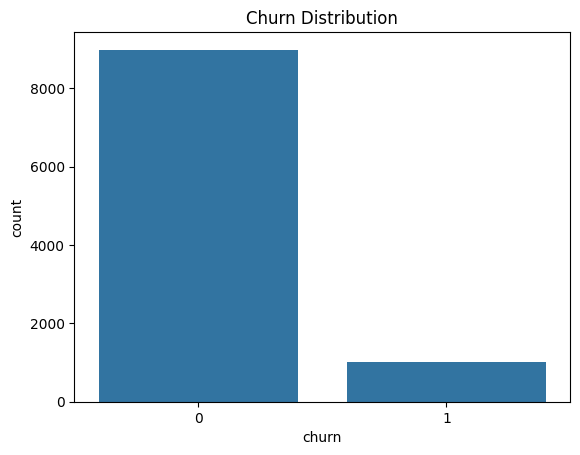

In [9]:
# target distribution plot
sns.countplot(x="churn", data=df)
plt.title("Churn Distribution")
plt.savefig("../outputs/figures/target_distribution.png")
plt.show()

The distribution of the target variable confirms that approximately 10.21% of customers are labelled as churners. The class imbalance is visually evident in the countplot, with churners representing a minority segment of the dataset.

This empirical observation aligns with the imbalance considerations discussed in Step 1 and will inform threshold-sensitive evaluation in later stages.

,missing,missing_pct
complaint_type,2045,0.2045


Text(0, 0.5, '% missing')

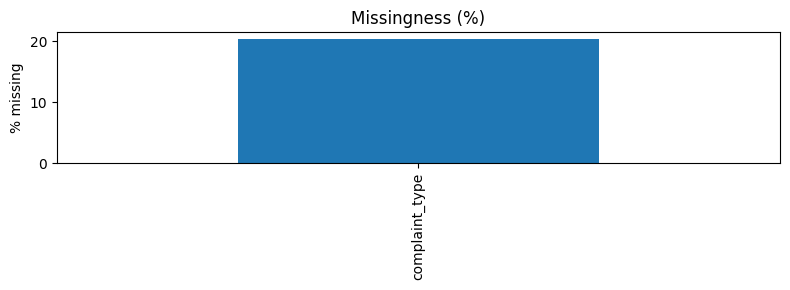

In [10]:
# Missing values analysis
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df)).sort_values(ascending=False)

missing_summary = (
    pd.DataFrame({"missing": missing, "missing_pct": missing_pct})
    .query("missing > 0")
)
display(missing_summary)

if not missing_summary.empty:
    ax = (missing_pct[missing_pct > 0] * 100).plot(kind="bar", figsize=(8, 3), title="Missingness (%)")
    ax.set_ylabel("% missing")
    plt.tight_layout()
    plt.show()

In [11]:
# duplicates
print("Duplicated rows:", df.duplicated().sum())
print("Duplicated customer_id:", df["customer_id"].duplicated().sum())

Duplicated rows: 0
Duplicated customer_id: 0


In [12]:
# Quick validity rules
checks = {
    "weekly_active_days_out_of_0_7": ~df["weekly_active_days"].between(0, 7),
    "email_open_rate_out_of_0_1": ~df["email_open_rate"].between(0, 1),
    "marketing_click_rate_out_of_0_1": ~df["marketing_click_rate"].between(0, 1),
}
for name, mask in checks.items():
    if name.split("_")[0] in df.columns:
        print(name, int(mask.sum()))

The dataset contains missing values concentrated exclusively in complaint_type (~20%). This pattern is structured rather than random and likely indicates absence of a complaint event.

No duplicate rows were detected, and bounded variables (e.g., rates between 0 and 1) fall within valid ranges. 

**3.1.2 Numerical Feature Distributions**

In [13]:
TARGET = "churn"

# Numerical columns (int + float), excluding target
num_cols = (
    df.select_dtypes(include=["int64", "float64"])
      .columns
      .drop(TARGET, errors="ignore")
      .tolist()
)

# Categorical columns (string/object)
cat_cols = df.select_dtypes(include=["object", "string"]).columns.tolist()

<Axes: xlabel='age', ylabel='Count'>

Text(0.5, 1.0, 'age')

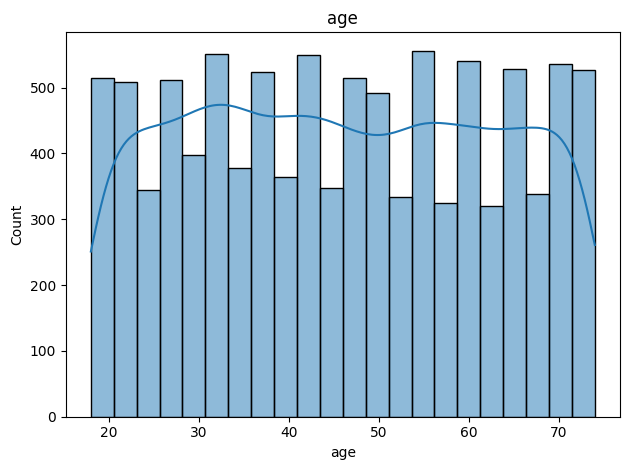

<Axes: xlabel='tenure_months', ylabel='Count'>

Text(0.5, 1.0, 'tenure_months')

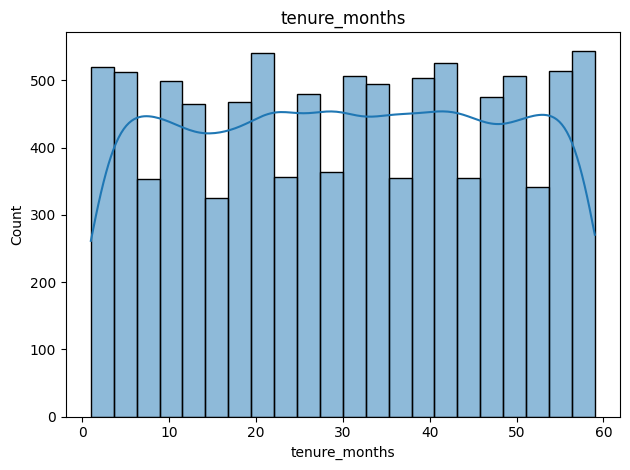

<Axes: xlabel='monthly_logins', ylabel='Count'>

Text(0.5, 1.0, 'monthly_logins')

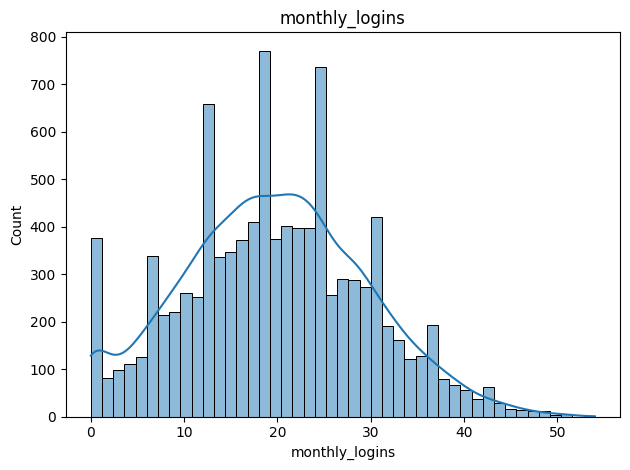

<Axes: xlabel='weekly_active_days', ylabel='Count'>

Text(0.5, 1.0, 'weekly_active_days')

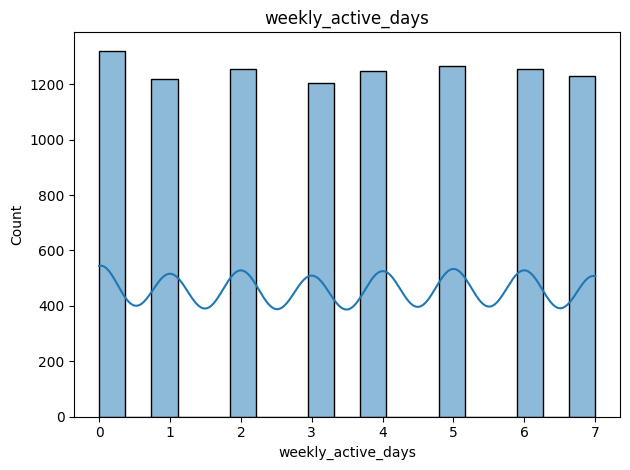

<Axes: xlabel='avg_session_time', ylabel='Count'>

Text(0.5, 1.0, 'avg_session_time')

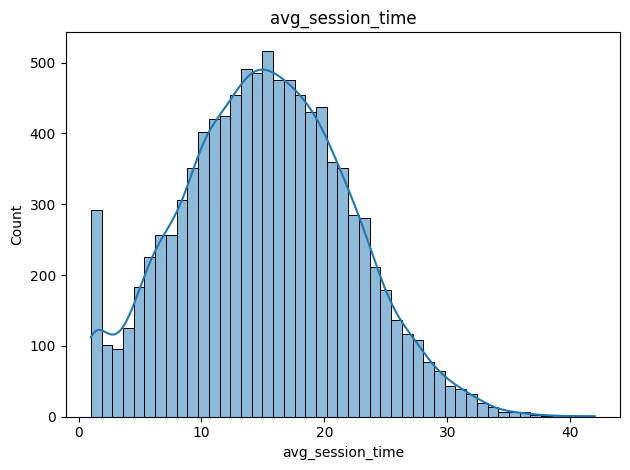

<Axes: xlabel='features_used', ylabel='Count'>

Text(0.5, 1.0, 'features_used')

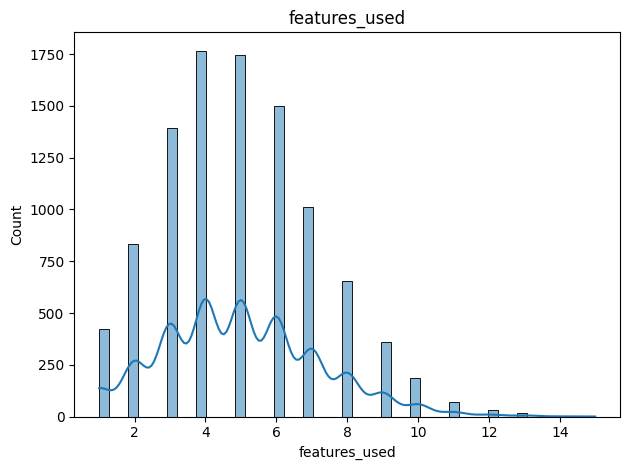

<Axes: xlabel='usage_growth_rate', ylabel='Count'>

Text(0.5, 1.0, 'usage_growth_rate')

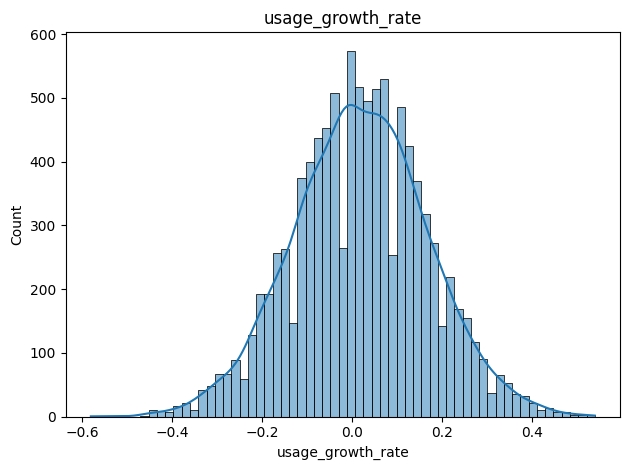

<Axes: xlabel='last_login_days_ago', ylabel='Count'>

Text(0.5, 1.0, 'last_login_days_ago')

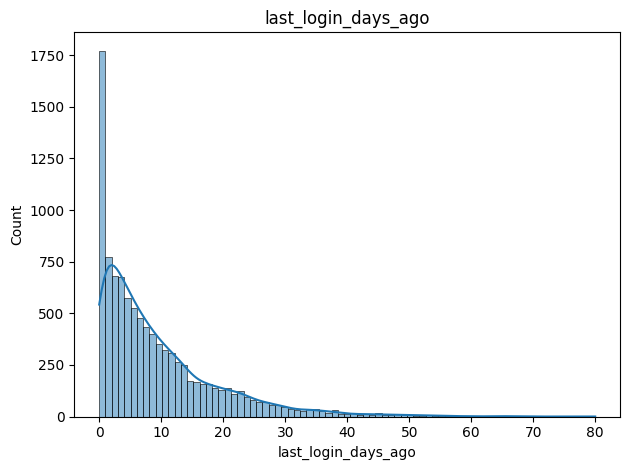

<Axes: xlabel='monthly_fee', ylabel='Count'>

Text(0.5, 1.0, 'monthly_fee')

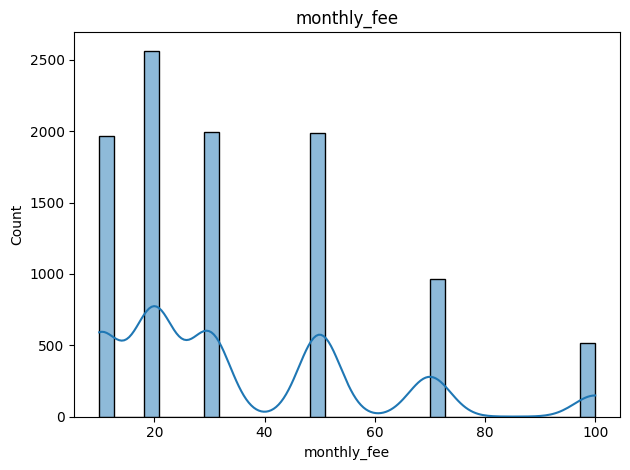

<Axes: xlabel='total_revenue', ylabel='Count'>

Text(0.5, 1.0, 'total_revenue')

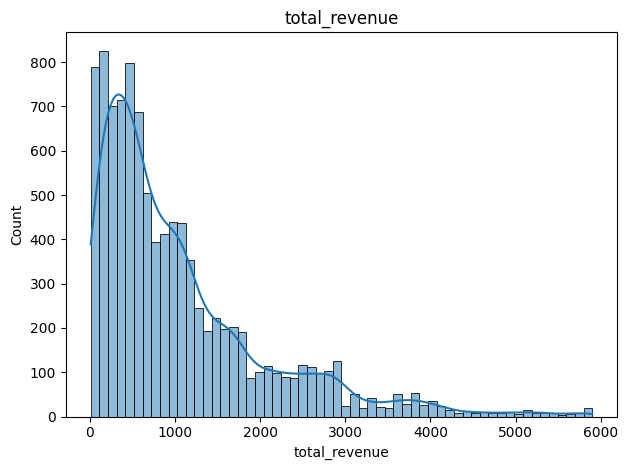

<Axes: xlabel='payment_failures', ylabel='Count'>

Text(0.5, 1.0, 'payment_failures')

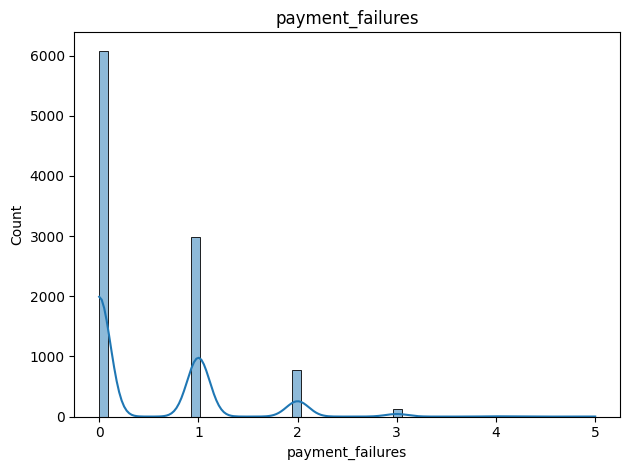

<Axes: xlabel='support_tickets', ylabel='Count'>

Text(0.5, 1.0, 'support_tickets')

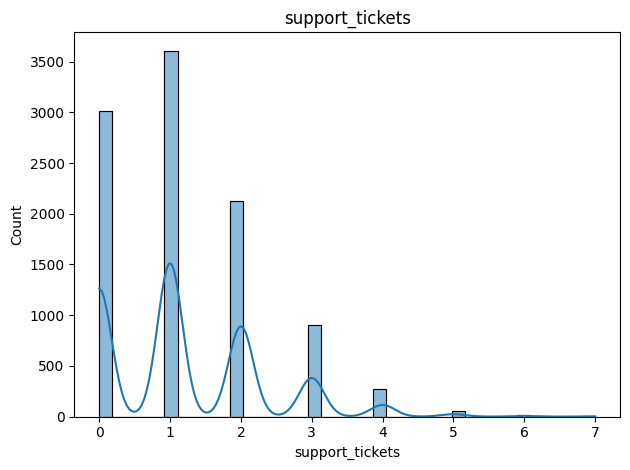

<Axes: xlabel='avg_resolution_time', ylabel='Count'>

Text(0.5, 1.0, 'avg_resolution_time')

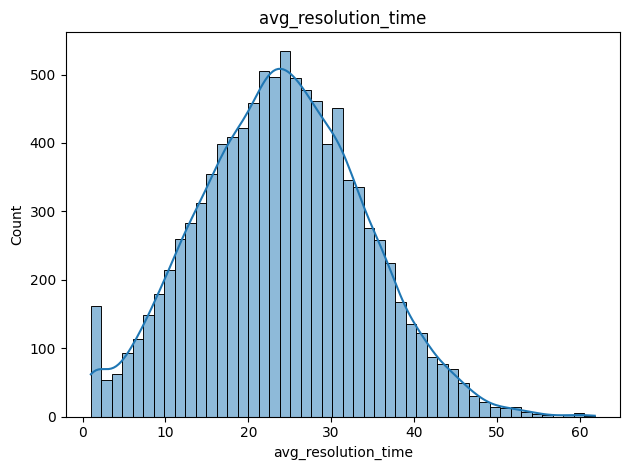

<Axes: xlabel='csat_score', ylabel='Count'>

Text(0.5, 1.0, 'csat_score')

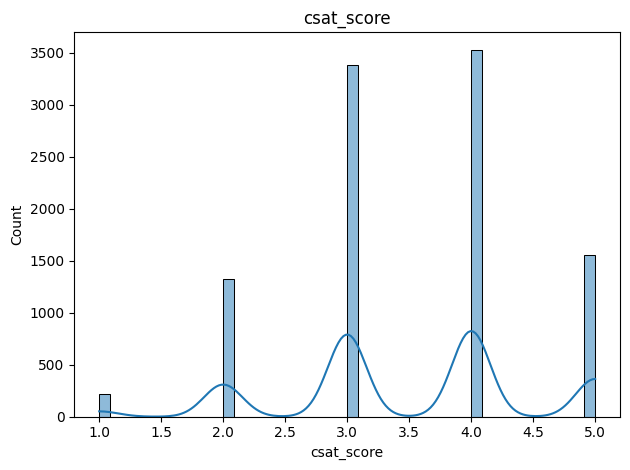

<Axes: xlabel='escalations', ylabel='Count'>

Text(0.5, 1.0, 'escalations')

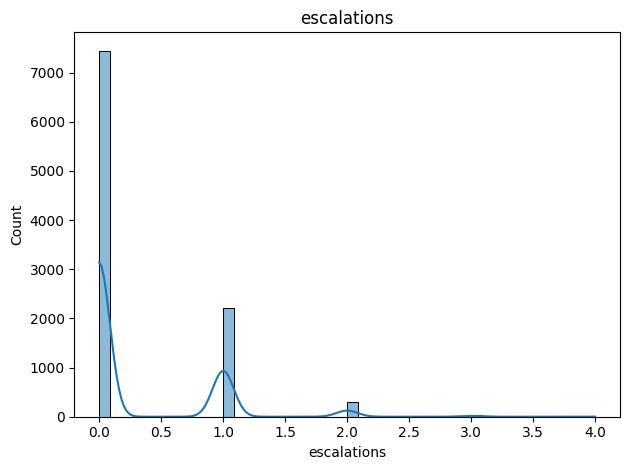

<Axes: xlabel='email_open_rate', ylabel='Count'>

Text(0.5, 1.0, 'email_open_rate')

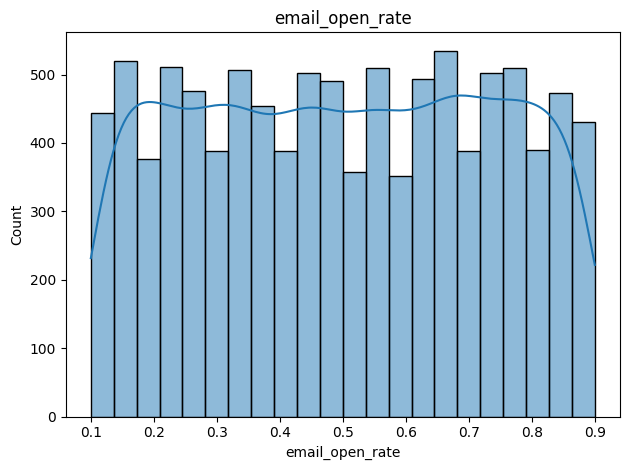

<Axes: xlabel='marketing_click_rate', ylabel='Count'>

Text(0.5, 1.0, 'marketing_click_rate')

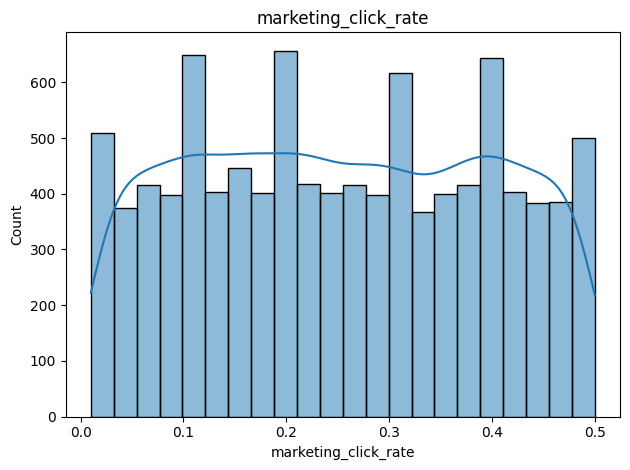

<Axes: xlabel='nps_score', ylabel='Count'>

Text(0.5, 1.0, 'nps_score')

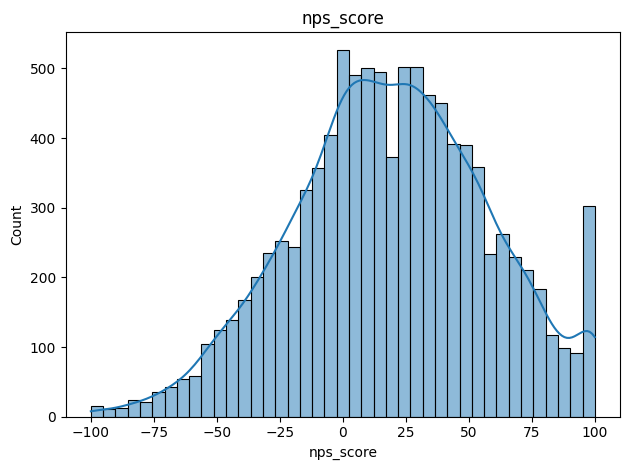

<Axes: xlabel='referral_count', ylabel='Count'>

Text(0.5, 1.0, 'referral_count')

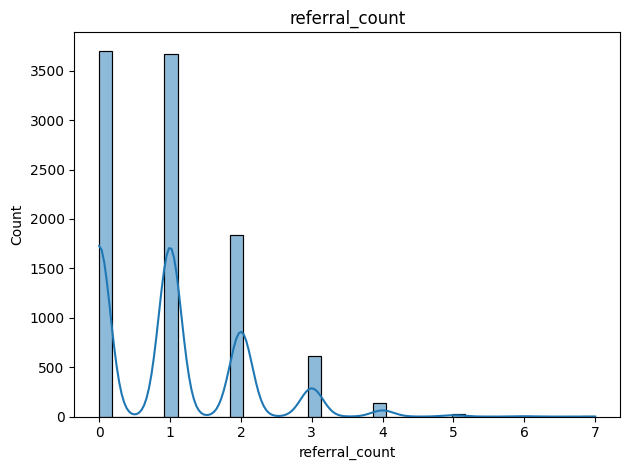

In [14]:
for col in num_cols:
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.tight_layout()
    plt.savefig(f"../outputs/figures/{col}_distribution.png")
    plt.show()

Several financial and recency-related variables (e.g., total_revenue, last_login_days_ago) exhibit pronounced right-skew, indicating a minority of high-intensity customers. In contrast, engagement duration metrics such as avg_session_time appear approximately symmetric. This heterogeneity suggests that different behavioural processes underlie revenue generation versus usage patterns.

In [15]:
display(df[num_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
age,10000.0,45.906100,16.420416,18.00,32.000000,46.000000,60.000000,74.000000
tenure_months,10000.0,30.155700,17.099517,1.00,16.000000,30.000000,45.000000,59.000000
monthly_logins,10000.0,19.672000,9.838003,0.00,13.000000,20.000000,26.000000,54.000000
weekly_active_days,10000.0,3.479400,2.302283,0.00,1.000000,3.000000,5.000000,7.000000
avg_session_time,10000.0,15.187890,6.830774,1.00,10.391645,15.161659,19.882034,41.996411
features_used,10000.0,4.990800,2.211607,1.00,3.000000,5.000000,6.000000,15.000000
usage_growth_rate,10000.0,0.019423,0.149567,-0.58,-0.080000,0.020000,0.120000,0.540000
last_login_days_ago,10000.0,9.505200,9.799417,0.00,2.000000,6.000000,13.000000,80.000000
monthly_fee,10000.0,34.930000,23.785115,10.00,20.000000,30.000000,50.000000,100.000000
total_revenue,10000.0,1057.018000,1020.148233,10.00,340.000000,720.000000,1440.000000,5900.000000


**3.1.3 Outlier Assessment**

In [16]:
outlier_pct = {}
skewness = {}

for c in num_cols:
    q1, q3 = df[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    
    outlier_pct[c] = ((df[c] < low) | (df[c] > high)).mean() * 100
    skewness[c] = df[c].skew()

outlier_pct_s = pd.Series(outlier_pct).sort_values(ascending=False).round(2)
skewness_s = pd.Series(skewness).sort_values(ascending=False).round(3)

print("Top 10 features by IQR-outlier percentage:")
display(outlier_pct_s.head(10))

print("Top 10 features by skewness:")
display(skewness_s.head(10))

outlier_pct_s.to_csv("../outputs/metrics/outlier_pct.csv")
skewness_s.to_csv("../outputs/metrics/skewness.csv")

Top 10 features by IQR-outlier percentage:


total_revenue          5.13
monthly_fee            5.13
last_login_days_ago    4.71
csat_score             2.21
payment_failures       1.47
features_used          1.21
usage_growth_rate      0.78
monthly_logins         0.49
escalations            0.43
avg_resolution_time    0.38
dtype: float64

Top 10 features by skewness:


escalations            1.895
last_login_days_ago    1.850
total_revenue          1.723
payment_failures       1.424
monthly_fee            1.119
referral_count         1.002
support_tickets        0.919
features_used          0.460
monthly_logins         0.137
avg_session_time       0.098
dtype: float64

Outliers were flagged using the 1.5×IQR rule. The highest outlier proportions are observed in total_revenue (5.13%), monthly_fee (5.13%), last_login_days_ago (4.71%), followed by csat_score (2.21%) and payment_failures (1.47%). Overall, the fraction of IQR-flagged points is moderate (mostly below ~5%), suggesting that extreme values are present but not dominant.

Skewness statistics provide additional context. Strong right‑skew is observed in escalations (1.895), last_login_days_ago (1.850), total_revenue (1.723), payment_failures (1.424), and monthly_fee (1.119)—patterns consistent with behavioural and financial variables where a small minority of customers may generate unusually high revenue, experience repeated payment failures, or exhibit rare escalation events. In contrast, features such as monthly_logins (0.137) and avg_session_time (0.098) are close to symmetric.

Given the moderate proportion of flagged observations and the expected right-tailed nature of revenue and behavioural metrics, these extreme values are interpreted as plausible high-intensity customer behaviour rather than data corruption. Therefore, no outlier removal is performed at this stage. Model robustness to skewed distributions will instead be addressed during modelling, where tree-based methods are generally resilient to extreme values and linear models can incorporate scaling or transformation if required.

**3.1.4 Numerical Feature Distributions by Churn**

In [17]:
df.groupby("churn").mean(numeric_only=True).T.sort_values(by=1, ascending=False)

effect_sizes = {}

for col in num_cols:
    mean_diff = df[df["churn"]==1][col].mean() - df[df["churn"]==0][col].mean()
    pooled_std = df[col].std()
    effect_sizes[col] = mean_diff / pooled_std

pd.Series(effect_sizes).sort_values(ascending=False)

churn,0,1
total_revenue,1081.138211,844.897160
age,45.849872,46.400588
monthly_fee,34.970487,34.573947
tenure_months,30.830382,24.222331
avg_resolution_time,23.984006,23.682382
nps_score,19.071166,19.456415
monthly_logins,19.998218,16.803134
avg_session_time,15.198622,15.093508
last_login_days_ago,9.382114,10.587659
features_used,4.986747,5.026445


payment_failures        0.371519
last_login_days_ago     0.123022
email_open_rate         0.038000
age                     0.033538
escalations             0.031577
features_used           0.017950
usage_growth_rate       0.017424
nps_score               0.009894
support_tickets         0.001048
marketing_click_rate   -0.006831
avg_session_time       -0.015388
monthly_fee            -0.016672
referral_count         -0.024185
weekly_active_days     -0.029123
avg_resolution_time    -0.030293
total_revenue          -0.231575
monthly_logins         -0.324770
tenure_months          -0.386447
csat_score             -0.521554
dtype: float64

Churned customers consistently exhibit lower engagement (monthly_logins), shorter tenure, and reduced satisfaction (csat_score), alongside higher operational friction (payment_failures, escalations). This pattern suggests churn is associated with both behavioural disengagement and service dissatisfaction rather than purely financial variables.

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='churn', ylabel='csat_score'>

Text(0.5, 1.0, 'csat_score Distribution by Churn')

Text(0.5, 0, 'Churn (0 = No, 1 = Yes)')

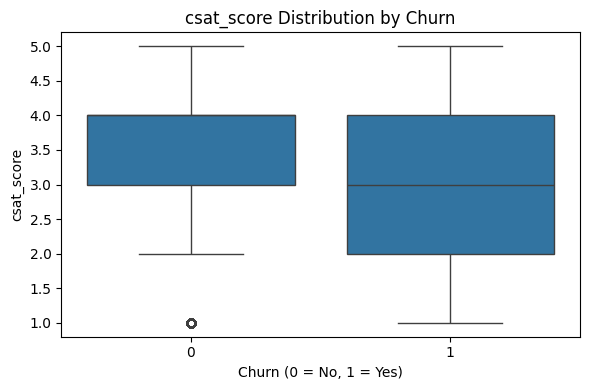

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='churn', ylabel='tenure_months'>

Text(0.5, 1.0, 'tenure_months Distribution by Churn')

Text(0.5, 0, 'Churn (0 = No, 1 = Yes)')

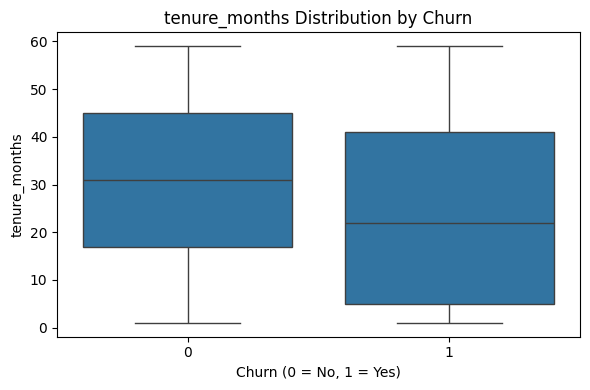

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='churn', ylabel='payment_failures'>

Text(0.5, 1.0, 'payment_failures Distribution by Churn')

Text(0.5, 0, 'Churn (0 = No, 1 = Yes)')

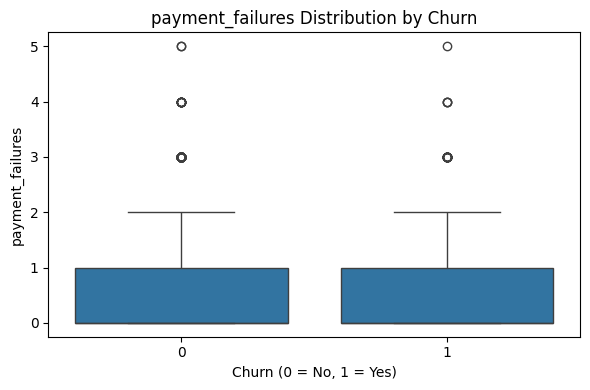

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='churn', ylabel='monthly_logins'>

Text(0.5, 1.0, 'monthly_logins Distribution by Churn')

Text(0.5, 0, 'Churn (0 = No, 1 = Yes)')

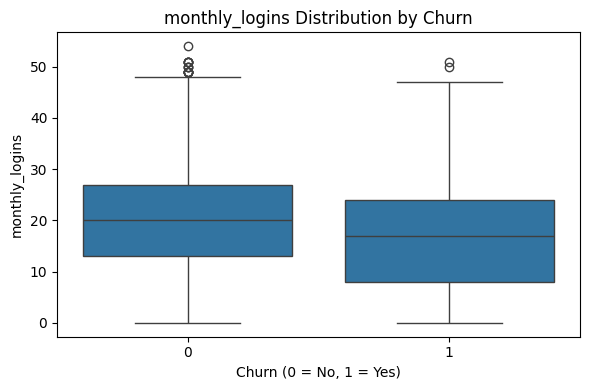

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='churn', ylabel='total_revenue'>

Text(0.5, 1.0, 'total_revenue Distribution by Churn')

Text(0.5, 0, 'Churn (0 = No, 1 = Yes)')

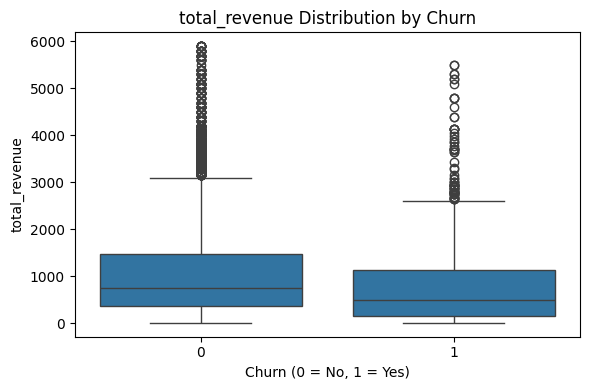

In [18]:
# Boxplots for selected numeric features by churn
import matplotlib.pyplot as plt
import seaborn as sns

selected_numeric = [
    "csat_score",
    "tenure_months",
    "payment_failures",
    "monthly_logins",
    "total_revenue"
]

for col in selected_numeric:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="churn", y=col)
    plt.title(f"{col} Distribution by Churn")
    plt.xlabel("Churn (0 = No, 1 = Yes)")
    plt.tight_layout()
    plt.savefig(f"../outputs/figures/{col}_boxplot.png")
    plt.show()

**3.1.5 Categorical Feature Distributions**

<Figure size 800x300 with 0 Axes>

<Axes: xlabel='customer_id'>

Text(0.5, 1.0, 'customer_id (top 10)')

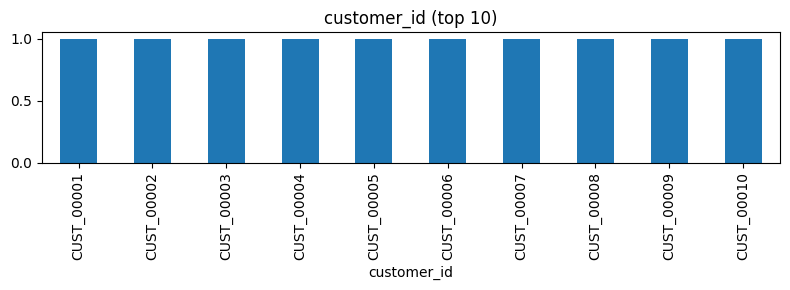

<Figure size 800x300 with 0 Axes>

<Axes: xlabel='gender'>

Text(0.5, 1.0, 'gender (top 10)')

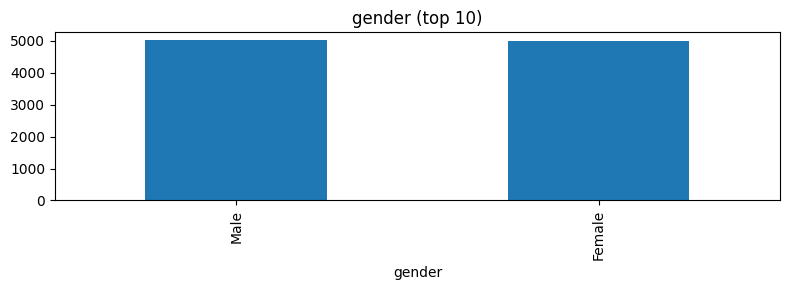

<Figure size 800x300 with 0 Axes>

<Axes: xlabel='country'>

Text(0.5, 1.0, 'country (top 10)')

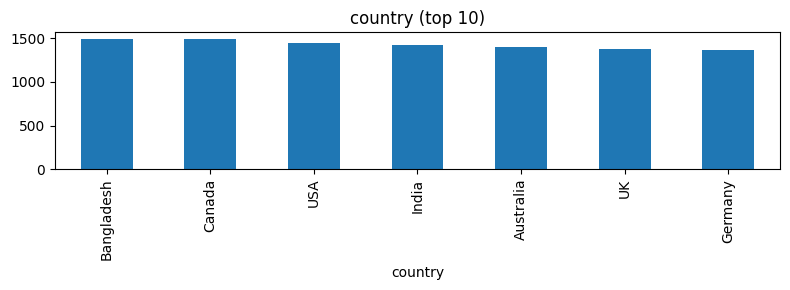

<Figure size 800x300 with 0 Axes>

<Axes: xlabel='city'>

Text(0.5, 1.0, 'city (top 10)')

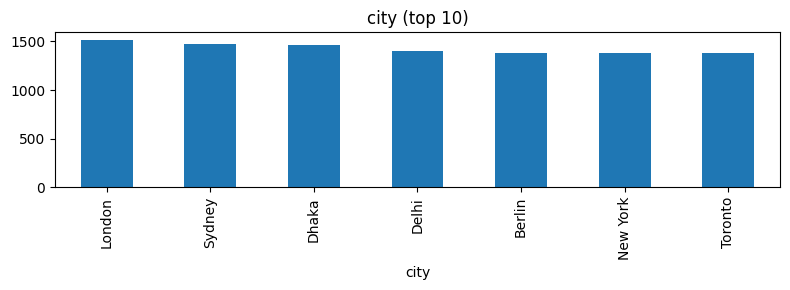

<Figure size 800x300 with 0 Axes>

<Axes: xlabel='customer_segment'>

Text(0.5, 1.0, 'customer_segment (top 10)')

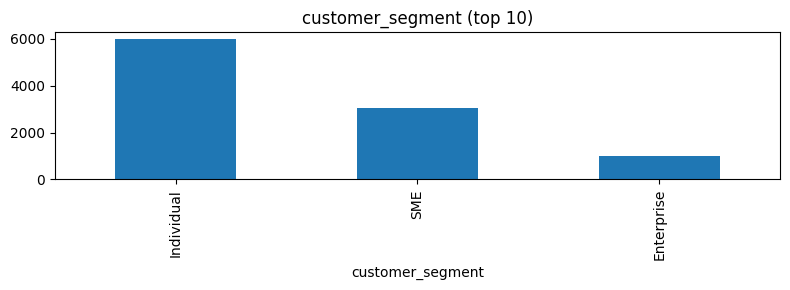

<Figure size 800x300 with 0 Axes>

<Axes: xlabel='signup_channel'>

Text(0.5, 1.0, 'signup_channel (top 10)')

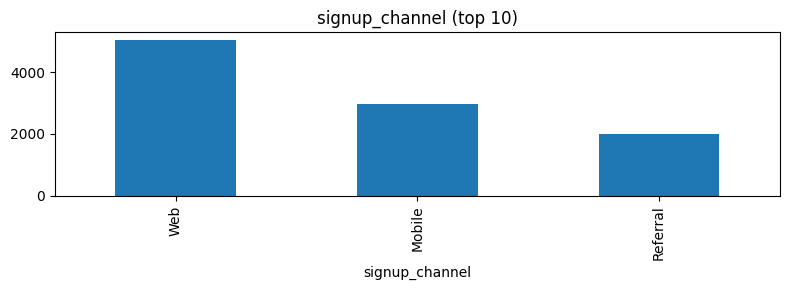

<Figure size 800x300 with 0 Axes>

<Axes: xlabel='contract_type'>

Text(0.5, 1.0, 'contract_type (top 10)')

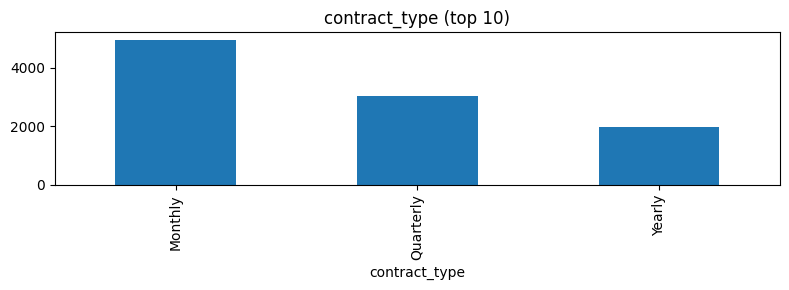

<Figure size 800x300 with 0 Axes>

<Axes: xlabel='payment_method'>

Text(0.5, 1.0, 'payment_method (top 10)')

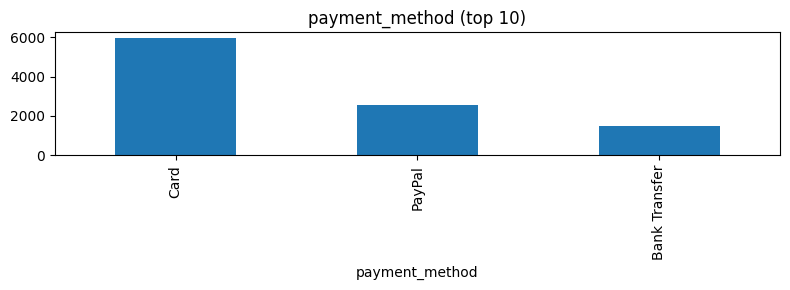

<Figure size 800x300 with 0 Axes>

<Axes: xlabel='discount_applied'>

Text(0.5, 1.0, 'discount_applied (top 10)')

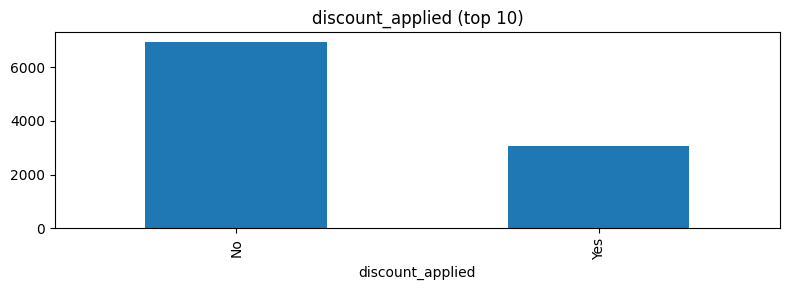

<Figure size 800x300 with 0 Axes>

<Axes: xlabel='price_increase_last_3m'>

Text(0.5, 1.0, 'price_increase_last_3m (top 10)')

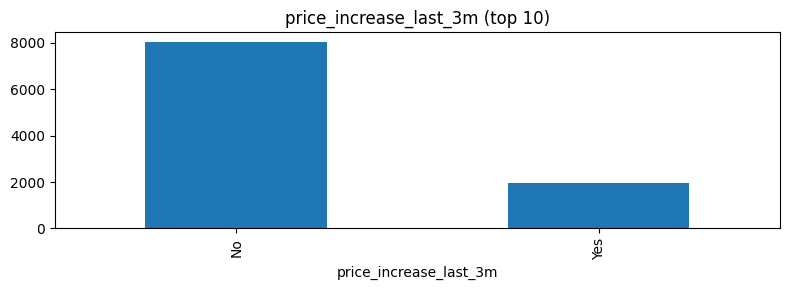

<Figure size 800x300 with 0 Axes>

<Axes: xlabel='complaint_type'>

Text(0.5, 1.0, 'complaint_type (top 10)')

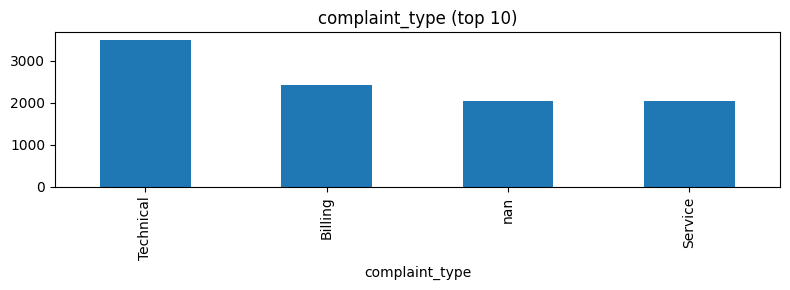

<Figure size 800x300 with 0 Axes>

<Axes: xlabel='survey_response'>

Text(0.5, 1.0, 'survey_response (top 10)')

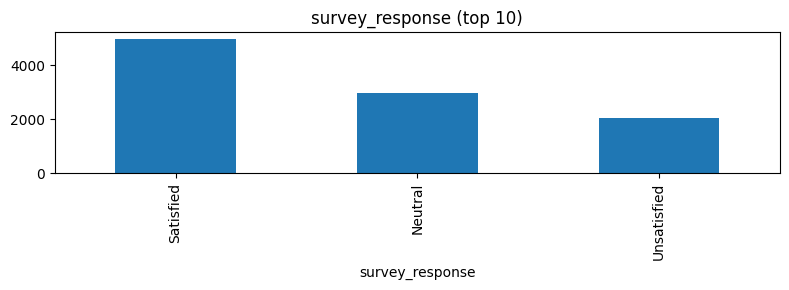

In [19]:
for c in cat_cols:
    plt.figure(figsize=(8, 3))
    df[c].value_counts(dropna=False).head(10).plot(kind="bar")
    plt.title(f"{c} (top 10)")
    plt.tight_layout()
    plt.savefig(f"../outputs/figures/{c}_distribution.png")
    plt.show()

**3.1.6 Categorical Feature Distributions by Churn**

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='gender', ylabel='count'>

([0, 1], [Text(0, 0, 'Male'), Text(1, 0, 'Female')])

Text(0.5, 1.0, 'gender — by Churn (Top 10 categories)')

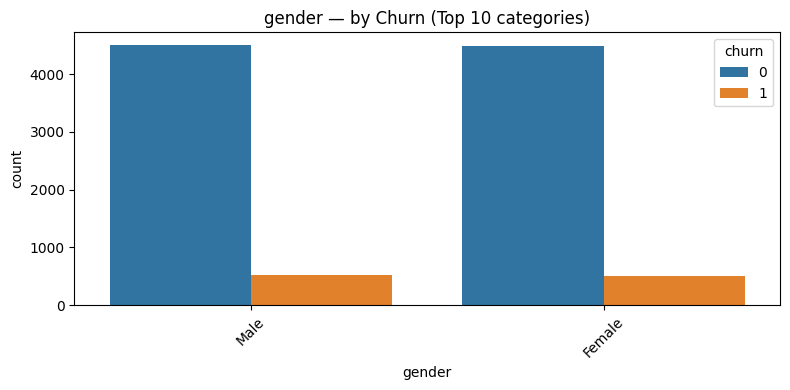

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='country', ylabel='count'>

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Bangladesh'),
  Text(1, 0, 'Canada'),
  Text(2, 0, 'USA'),
  Text(3, 0, 'India'),
  Text(4, 0, 'Australia'),
  Text(5, 0, 'UK'),
  Text(6, 0, 'Germany')])

Text(0.5, 1.0, 'country — by Churn (Top 10 categories)')

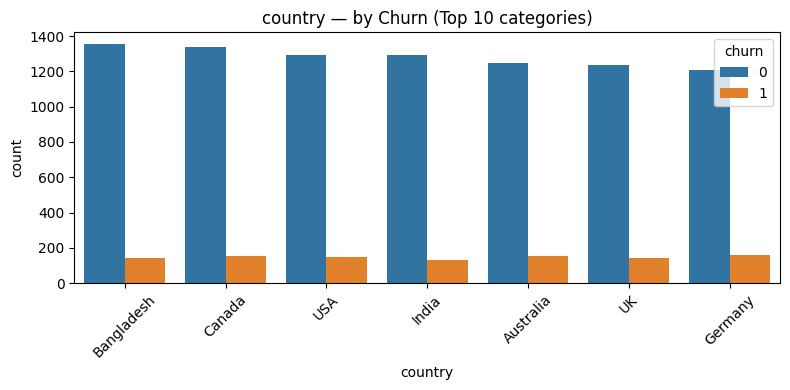

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='city', ylabel='count'>

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'London'),
  Text(1, 0, 'Sydney'),
  Text(2, 0, 'Dhaka'),
  Text(3, 0, 'Delhi'),
  Text(4, 0, 'Berlin'),
  Text(5, 0, 'New York'),
  Text(6, 0, 'Toronto')])

Text(0.5, 1.0, 'city — by Churn (Top 10 categories)')

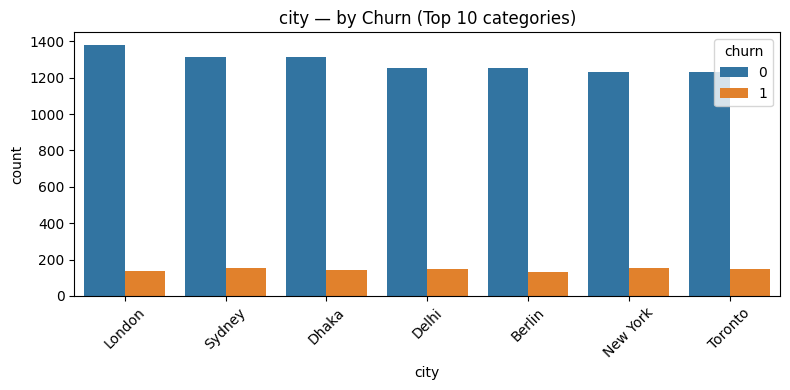

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='customer_segment', ylabel='count'>

([0, 1, 2],
 [Text(0, 0, 'Individual'), Text(1, 0, 'SME'), Text(2, 0, 'Enterprise')])

Text(0.5, 1.0, 'customer_segment — by Churn (Top 10 categories)')

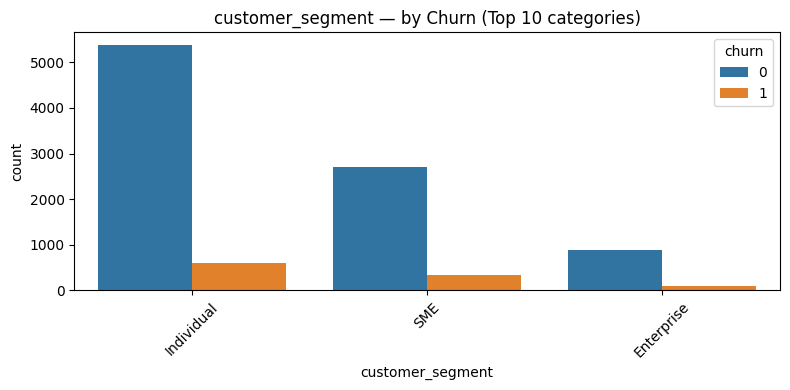

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='signup_channel', ylabel='count'>

([0, 1, 2], [Text(0, 0, 'Web'), Text(1, 0, 'Mobile'), Text(2, 0, 'Referral')])

Text(0.5, 1.0, 'signup_channel — by Churn (Top 10 categories)')

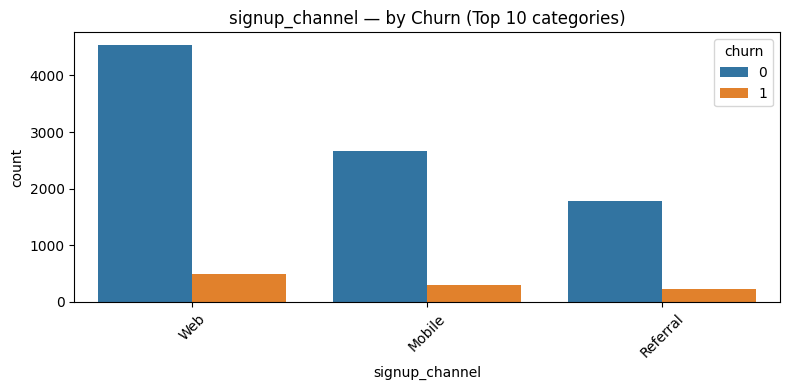

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='contract_type', ylabel='count'>

([0, 1, 2],
 [Text(0, 0, 'Monthly'), Text(1, 0, 'Quarterly'), Text(2, 0, 'Yearly')])

Text(0.5, 1.0, 'contract_type — by Churn (Top 10 categories)')

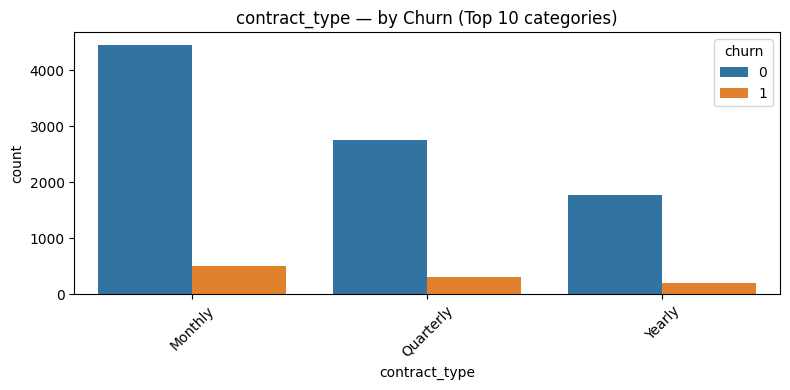

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='payment_method', ylabel='count'>

([0, 1, 2],
 [Text(0, 0, 'Card'), Text(1, 0, 'PayPal'), Text(2, 0, 'Bank Transfer')])

Text(0.5, 1.0, 'payment_method — by Churn (Top 10 categories)')

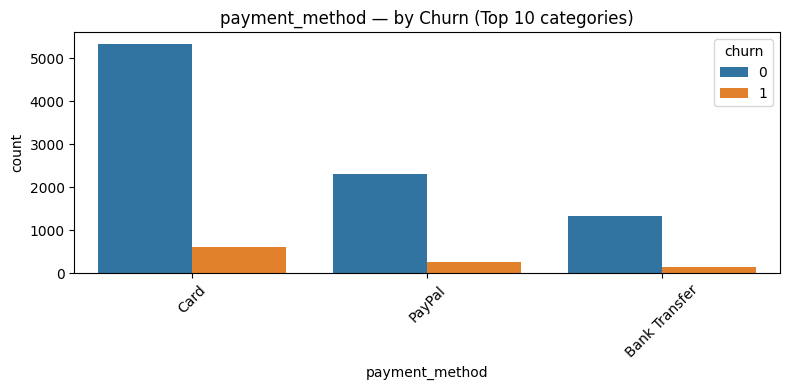

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='discount_applied', ylabel='count'>

([0, 1], [Text(0, 0, 'No'), Text(1, 0, 'Yes')])

Text(0.5, 1.0, 'discount_applied — by Churn (Top 10 categories)')

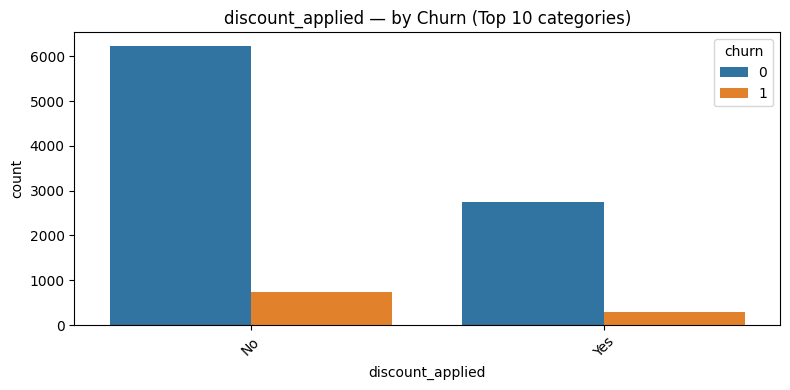

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='price_increase_last_3m', ylabel='count'>

([0, 1], [Text(0, 0, 'No'), Text(1, 0, 'Yes')])

Text(0.5, 1.0, 'price_increase_last_3m — by Churn (Top 10 categories)')

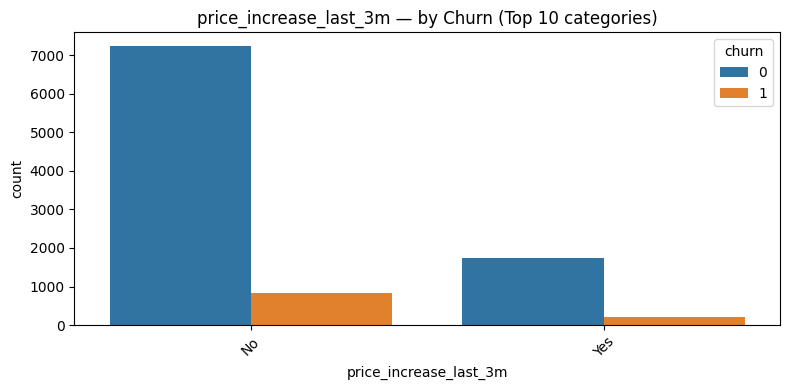

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='complaint_type', ylabel='count'>

([0, 1, 2],
 [Text(0, 0, 'Technical'), Text(1, 0, 'Billing'), Text(2, 0, 'Service')])

Text(0.5, 1.0, 'complaint_type — by Churn (Top 10 categories)')

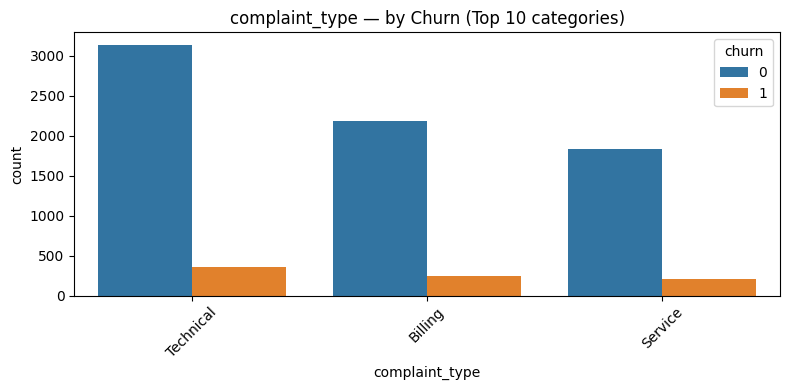

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='survey_response', ylabel='count'>

([0, 1, 2],
 [Text(0, 0, 'Satisfied'), Text(1, 0, 'Neutral'), Text(2, 0, 'Unsatisfied')])

Text(0.5, 1.0, 'survey_response — by Churn (Top 10 categories)')

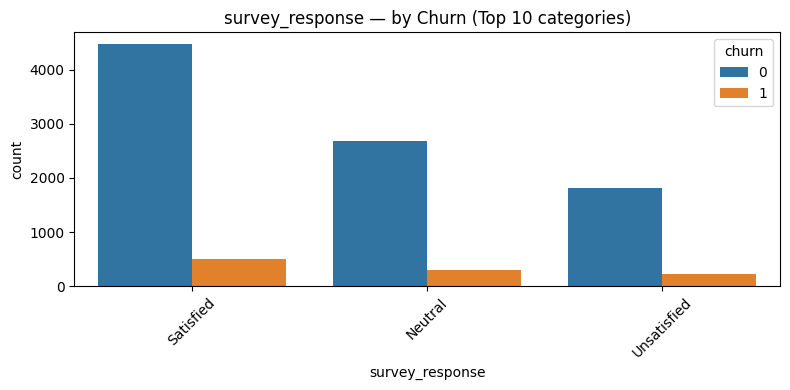

In [20]:
cat_cols = df.select_dtypes(include=["object","string"]).columns.tolist()

# Remove identifier columns
cat_cols = [col for col in cat_cols if col not in ["customer_id"]]

for col in cat_cols:
    vc = df[col].value_counts()
    top = vc.head(10).index
    
    plot_df = df[df[col].isin(top)].copy()
    
    plt.figure(figsize=(8,4))
    sns.countplot(data=plot_df, x=col, hue=TARGET, order=top)
    plt.xticks(rotation=45)
    plt.title(f"{col} — by Churn (Top 10 categories)")
    plt.tight_layout()
    plt.savefig(f"../outputs/figures/{col}_by_churn_top10.png")
    plt.show()

In [21]:
# Churn rate table by category for categorical features
for col in cat_cols:
    churn_table = pd.crosstab(df[col], df[TARGET], normalize="index")
    churn_table = churn_table.sort_values(by=1, ascending=False)
    print(f"\n--- {col}: churn rate by category ---")
    display(churn_table)


--- gender: churn rate by category ---


churn,0,1
gender,,
Male,0.896868,0.103132
Female,0.898937,0.101063



--- country: churn rate by category ---


churn,0,1
country,,
Germany,0.885150,0.114850
Australia,0.891429,0.108571
UK,0.896527,0.103473
Canada,0.897849,0.102151
USA,0.898752,0.101248
Bangladesh,0.906292,0.093708
India,0.908199,0.091801



--- city: churn rate by category ---


churn,0,1
city,,
New York,0.888809,0.111191
Toronto,0.893401,0.106599
Sydney,0.893950,0.106050
Delhi,0.894437,0.105563
Dhaka,0.901302,0.098698
Berlin,0.903319,0.096681
London,0.909091,0.090909



--- customer_segment: churn rate by category ---


churn,0,1
customer_segment,,
SME,0.890723,0.109277
Individual,0.900234,0.099766
Enterprise,0.905775,0.094225



--- signup_channel: churn rate by category ---


churn,0,1
signup_channel,,
Referral,0.888224,0.111776
Mobile,0.900000,0.100000
Web,0.900516,0.099484



--- contract_type: churn rate by category ---


churn,0,1
contract_type,,
Yearly,0.896621,0.103379
Monthly,0.896718,0.103282
Quarterly,0.900656,0.099344



--- payment_method: churn rate by category ---


churn,0,1
payment_method,,
Card,0.896054,0.103946
PayPal,0.900274,0.099726
Bank Transfer,0.901210,0.098790



--- discount_applied: churn rate by category ---


churn,0,1
discount_applied,,
No,0.895252,0.104748
Yes,0.903934,0.096066



--- price_increase_last_3m: churn rate by category ---


churn,0,1
price_increase_last_3m,,
Yes,0.896144,0.103856
No,0.898324,0.101676



--- complaint_type: churn rate by category ---


churn,0,1
complaint_type,,
Technical,0.896798,0.103202
Billing,0.898228,0.101772
Service,0.900493,0.099507



--- survey_response: churn rate by category ---


churn,0,1
survey_response,,
Unsatisfied,0.888617,0.111383
Satisfied,0.898693,0.101307
Neutral,0.902955,0.097045


A concise and accurate illustration is that churn proportions across all categorical groups sit within a very narrow band, showing only marginal separation. The differences between categories are typically within one to two percentage points, which indicates that these attributes do not meaningfully distinguish churners from non‑churners. Behavioural and engagement variables, rather than demographic or static categories, are likely to be the primary drivers of churn patterns.

In [22]:
os.makedirs("../outputs/metrics/cat_churn_tables", exist_ok=True)

for col in cat_cols:
    churn_table = pd.crosstab(df[col], df[TARGET], normalize="index").sort_values(by=1, ascending=False)
    churn_table.to_csv(f"../outputs/metrics/cat_churn_tables/{col}_churn_rate.csv")

#### 3.2 Data Quality and Likely Modelling Pitfalls 

Exploratory analysis reveals several structural characteristics of the dataset that may influence modelling performance and interpretation.

First, missingness is concentrated in the complaint_type variable (approximately 20%). The pattern appears structured rather than random and likely reflects the absence of a complaint event rather than data corruption. However, if missingness is systematically associated with churn behaviour, naïve imputation may introduce bias. This variable therefore requires explicit handling during preprocessing to avoid distortion of signal.

Second, several categorical variables (e.g., city) exhibit high cardinality. Direct one-hot encoding of such variables may introduce sparsity, increase dimensionality, and amplify overfitting risk, particularly for linear models. Feature grouping or regularised models may therefore be necessary to maintain generalisability.

Third, multiple financial and behavioural variables (e.g., total_revenue, last_login_days_ago, escalations) exhibit pronounced right-skew and moderate IQR-flagged outliers. While these patterns are consistent with heavy-tailed business behaviour, they may affect models sensitive to scale or leverage, particularly linear classifiers. Appropriate scaling or transformation strategies will be considered where necessary.

Additionally, the target variable exhibits moderate class imbalance (~10% churn rate). Without adjustment, standard classifiers may bias toward the majority class, leading to inflated accuracy but poor minority-class detection. Evaluation strategies must therefore prioritise recall-sensitive and threshold-independent metrics.

There is also potential multicollinearity among certain numerical features, particularly those reflecting related behavioural dimensions (e.g., tenure and cumulative revenue, satisfaction-related metrics). While tree-based models are generally robust to correlated predictors, linear models may experience coefficient instability under high correlation.

Finally, the absence of timestamps introduces structural uncertainty regarding temporal ordering. Some features (e.g., satisfaction scores or escalation counts) may reflect events temporally close to churn. Although no explicit target proxy is observed, this limitation constrains our ability to fully rule out temporal leakage.

These considerations do not invalidate the modelling task but inform preprocessing design, model selection, and evaluation strategy in subsequent stages.

#### 3.3 Leakage Risks Assessment

Since the dataset does not include timestamps, we cannot directly verify the temporal ordering between feature collection and the churn event. Therefore, leakage risk must be assessed conceptually.

Temporal Availability Assumption <br>
Features such as csat_score, nps_score, avg_resolution_time, payment_failures, total_revenue may reflect customer dissatisfaction or behavioural outcomes close to or after churn decision. We assume that these features represent information available prior to churn and would be accessible at prediction time. However, the absence of timestamps introduces uncertainty regarding true temporal alignment.

Post-Outcome Aggregation Risk <br>
Aggregated variables such as total_revenue and tenure_months may incorporate behaviour over the full customer lifetime. If churn is defined at the end of that same lifetime, these features could partially encode outcome information. We assume that revenue and tenure reflect cumulative historical data up to the prediction point rather than post-churn summaries.

Train/Test Leakage Control <br>
To prevent procedural leakage during modelling, all preprocessing steps will be fit only on training data. This will be enforced in the preprocessing pipeline in Step 3.

#### 3.4 Agent Tooling

During exploratory analysis, the agent was used in a structured and controlled manner to:

1）propose initial visualisation strategies (e.g., distribution plots, boxplots, countplots)； 

2）highlight potential leakage-sensitive variables based on feature semantics； 

3）suggest improved comparison methods beyond raw mean differences by implementing relative (percentage) difference comparisons which avoids scale distortion and provides a more interpretable measure of separation strength across variables with different magnitudes.

All visual outputs and comparative metrics were manually reviewed to ensure that interpretations aligned with statistical evidence rather than visual intuition.

### 4. Prepare the Data

#### 4.1 Implementation Structure and Reproducibility

This stage converts the raw dataset into inputs suitable for modelling while maintaining a strict division between training, validation, and test sets. The aim is to prevent any form of information leakage, ensure that preprocessing steps can be reproduced consistently, and keep structural cleaning clearly separated from transformations that depend on the chosen model.

All preprocessing logic is implemented as modular Python components under the src/ directory and executed through a dedicated script (scripts/prepare_data.py). This structure ensures that the preprocessing pipeline is defined once and reused consistently, that data splits are generated programmatically and written to data/processed/, and that the notebook is used primarily for inspection and validation rather than transformation. By separating preprocessing from exploratory analysis, the workflow avoids hidden state dependencies and strengthens reproducibility.

#### 4.2 Structural Cleaning (Pre-Split)

Before splitting, only structural operations that do not use label information were applied including removal of duplicate rows and identifier columns (e.g., customer_id), target extraction (churn), and validation checks for bounded variables (e.g., rates in [0,1], weekly days in [0,7]).

No feature engineering based on target distribution was performed at this stage which ensures preprocessing remains unbiased and does not condition on future information.

#### 4.3 Train / Validation / Test Split Discipline

The dataset was divided using a stratified procedure that preserved the underlying churn distribution, which is approximately 10%. Twenty percent of the full sample was held out as the test set. From the remaining data, a further 20% was allocated to validation, leaving 64% for training.

This structure ensures that the test set remains completely untouched until final evaluation, that hyperparameter tuning relies solely on the validation split, and that all preprocessing statistics are derived exclusively from the training data to avoid any form of procedural leakage.

In [23]:
import pandas as pd
from src.config import PROCESSED_DIR

X_train = pd.read_csv(PROCESSED_DIR / "X_train.csv")
y_train = pd.read_csv(PROCESSED_DIR / "y_train.csv").iloc[:, 0]
X_val   = pd.read_csv(PROCESSED_DIR / "X_val.csv")
y_val   = pd.read_csv(PROCESSED_DIR / "y_val.csv").iloc[:, 0]
X_test  = pd.read_csv(PROCESSED_DIR / "X_test.csv")
y_test  = pd.read_csv(PROCESSED_DIR / "y_test.csv").iloc[:, 0]

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Churn rates:", y_train.mean(), y_val.mean(), y_test.mean())

Shapes: (6400, 30) (1600, 30) (2000, 30)
Churn rates: 0.1021875 0.101875 0.102


#### 4.4 Reproducible Preprocessing Pipeline

A ColumnTransformer was used to standardise preprocessing in a reproducible way. Numeric variables undergo median imputation, followed by standard scaling when required by linear models. Categorical variables are imputed using the most frequent category and then encoded through one‑hot encoding with handle_unknown="ignore" to ensure stability when new categories appear at inference time. The transformer is defined but intentionally left unfitted at this stage; it will be fitted later within the modelling pipeline using only the training split. This design prevents procedural leakage, such as computing scaling parameters from the full dataset or learning categorical levels that appear only in the validation or test sets.

#### 4.5 Data Validation Checks

Basic validation diagnostics were documented, covering dataset dimensions, the distribution of the target variable, proportions of missing values, the presence of duplicates, and any violations of expected bounds for constrained variables. 

No indications of severe data corruption were found. 

The observed outliers are consistent with heavy‑tailed patterns typical of real business processes rather than signs of measurement error.

#### 4.6 Agent Tooling

The AI agent supported: 1) Structuring the modular preprocessing pipeline; 2) Suggesting stratified splitting to preserve class balance; 3) Proposing median imputation and robust scaling choices.

All suggestions were manually reviewed to ensure: 1) No transformation used target information; 2) Splitting occurred before any statistical fitting; 3) Preprocessing steps are compatible with downstream modelling.

The agent did not autonomously decide feature removals; any potential leakage variables remain explicitly controlled via a flag parameter (drop_leakage), ensuring experimental transparency.

### 5. Explore Different Models and Shortlist

This step compares multiple model families under the same preprocessing pipeline and identical train/validation split to identify the most suitable approach for churn prediction. We evaluate an interpretable baseline (Logistic Regression), a nonlinear ensemble baseline (Random Forest), modern gradient-boosted tree models (LightGBM and XGBoost) and EBM. Models are compared using ROC curves, precision–recall curves, confusion matrices, and calibration plots

The objective is to determine which model demonstrates the highest level of stability and reproducibility for churn prediction, particularly under class imbalance. Stability in this context refers to consistent ranking performance, predictable behaviour across thresholds, robustness to skewed class distributions, and reliable probability calibration.


#### 5.1 Baseline and Other Model Training

Logistic Regression was selected as a baseline due to its interpretability and established performance in tabular binary classification tasks. Class weights were balanced to account for class imbalance (~10% churn). This provides a transparent performance benchmark against which more complex models can be compared.

In [24]:
import subprocess, sys
subprocess.run([sys.executable, "-m", "scripts.train"], check=False)

CompletedProcess(args=['d:\\Software\\vscode\\HelloWorld\\msin0097-e2e predictive system\\venv311\\Scripts\\python.exe', '-m', 'scripts.train'], returncode=1)

In [25]:
# Load lastest run output
import json
import pandas as pd
from pathlib import Path

runs_dir = PROJECT_ROOT / "outputs" / "runs"
candidates = list(runs_dir.glob("step4_*"))
latest_run = max(candidates, key=lambda p: p.stat().st_mtime)
print("Latest run:", latest_run)

met_dir = latest_run / "metrics"
json_files = sorted(met_dir.glob("*_metrics.json"))
print("Found metric jsons:", [p.name for p in json_files])

rows = []
for jf in json_files:
    rows.append(json.loads(jf.read_text(encoding="utf-8")))

results_df = pd.DataFrame(rows).sort_values(by=["roc_auc", "recall"], ascending=False)
results_df

Latest run: D:\Software\vscode\HelloWorld\msin0097-e2e predictive system\outputs\runs\step4_20260227_041522
Found metric jsons: ['EBM_metrics.json', 'LightGBM_metrics.json', 'LogisticRegression_metrics.json', 'RandomForest_metrics.json', 'XGBoost_metrics.json']


,threshold,roc_auc,pr_auc,precision,recall,f1,tp,fp,tn,fn,brier,model
3,0.5,0.820724,0.280189,0.000000,0.000000,0.000000,0,0,1437,163,0.080428,RandomForest
0,0.5,0.817001,0.307177,0.404762,0.104294,0.165854,17,25,1412,146,0.081132,EBM
4,0.5,0.779922,0.276828,0.318182,0.128834,0.183406,21,45,1392,142,0.094731,XGBoost
1,0.5,0.768553,0.260950,0.285714,0.110429,0.159292,18,45,1392,145,0.097577,LightGBM
2,0.5,0.709535,0.203542,0.179715,0.619632,0.278621,101,461,976,62,0.210172,LogisticRegression


In [26]:
out_csv = met_dir / "model_comparison_val.csv"
results_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)

Saved: D:\Software\vscode\HelloWorld\msin0097-e2e predictive system\outputs\runs\step4_20260227_041522\metrics\model_comparison_val.csv


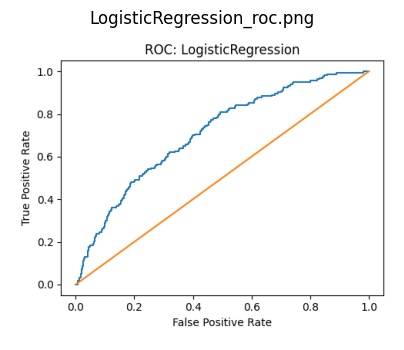

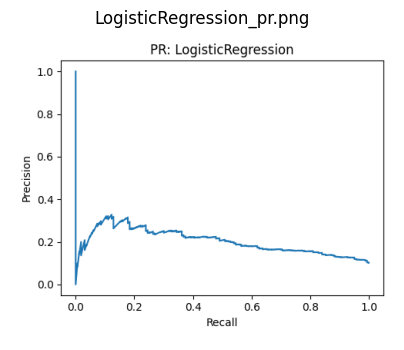

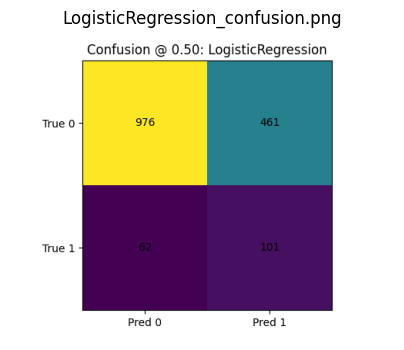

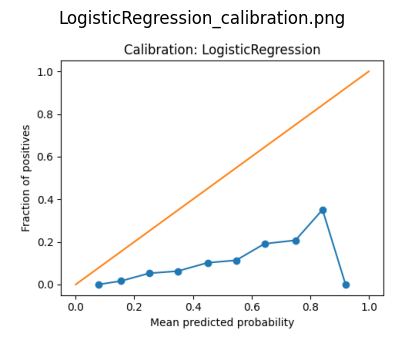

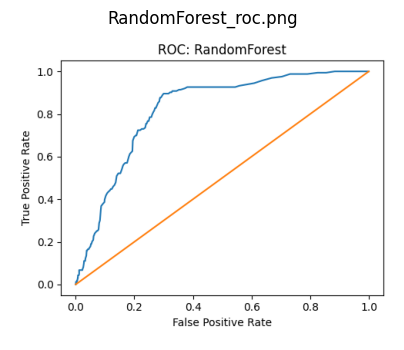

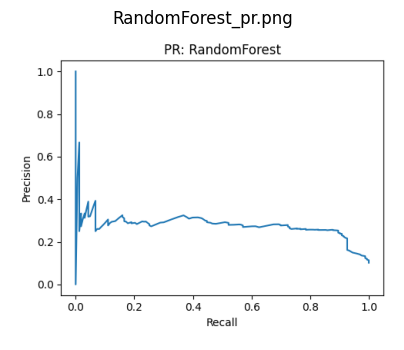

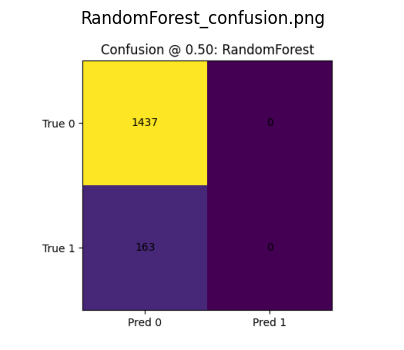

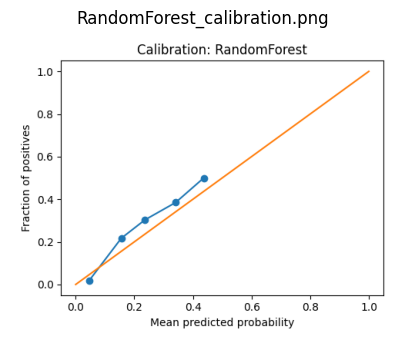

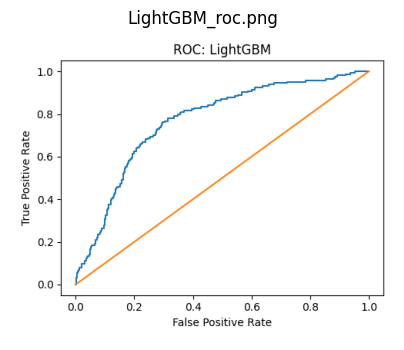

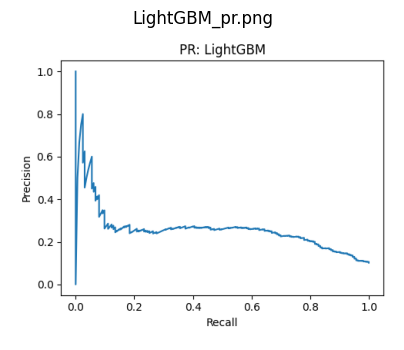

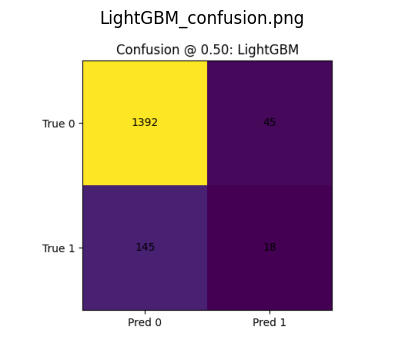

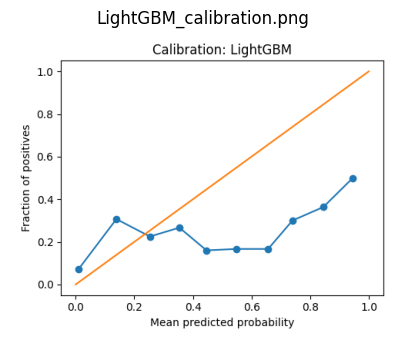

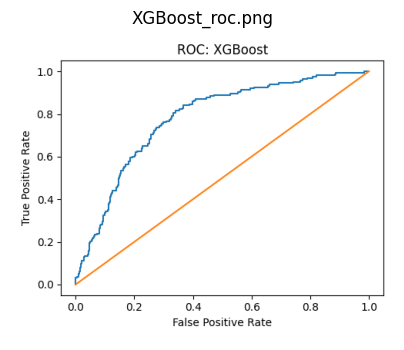

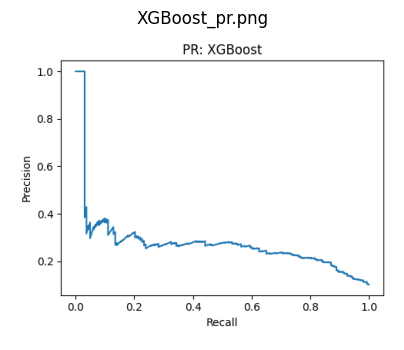

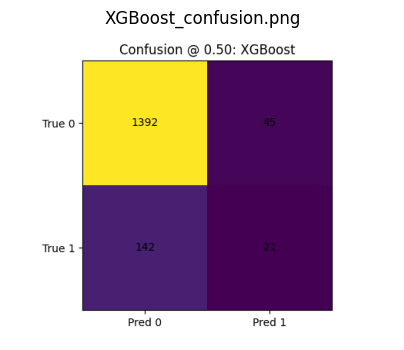

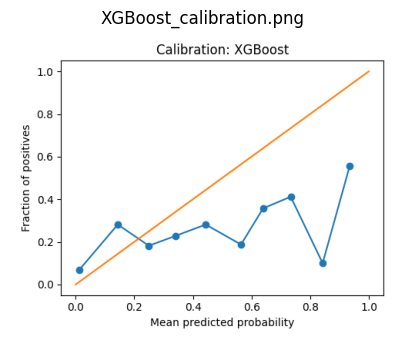

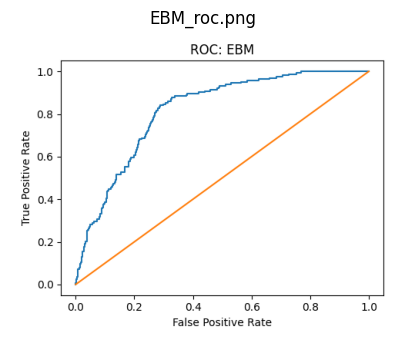

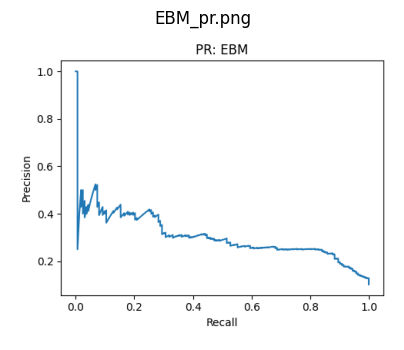

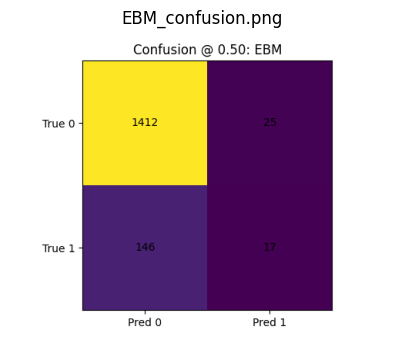

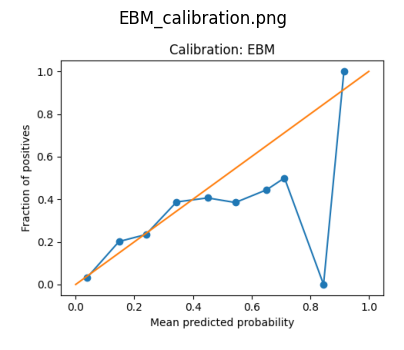

In [27]:
# Show plots for each model
from PIL import Image
import matplotlib.pyplot as plt
import xgboost
import lightgbm
import interpret

fig_dir = latest_run / "figures"

MODEL_ORDER = ["LogisticRegression", "RandomForest", "LightGBM", "XGBoost", "EBM"]
PLOT_ORDER = ["roc", "pr", "confusion", "calibration"]

def show_img(path):
    img = Image.open(path)
    plt.figure(figsize=(6,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(path.name)
    plt.show()

for model_name in MODEL_ORDER:
    found_any = False
    for suffix in PLOT_ORDER:
        p = fig_dir / f"{model_name}_{suffix}.png"
        if p.exists():
            found_any = True
            show_img(p)
    if not found_any:
        print(f"(No plots found for {model_name} in this run — likely not trained or skipped.)")

#### 5.2 Stability Observation and Comparison

**Logistic Regression**

Logistic Regression shows the lowest ROC‑AUC and PR‑AUC values, indicating weaker ranking performance. Its calibration curve deviates substantially from the ideal diagonal, suggesting unreliable probability estimates. The confusion matrix reveals an extremely high false‑positive rate at the default threshold, which makes its predictions unstable for churn prediction. While the model is mathematically simple and interpretable, its empirical behaviour in this task is not stable.

**RandomForest**

RandomForest exhibits the strongest underlying predictive structure. Its ROC‑AUC and PR‑AUC values are the highest among all models, indicating superior ranking ability and robustness in identifying churners even under class imbalance. The Brier score is also the lowest, suggesting that its predicted probabilities are more reliable and better calibrated. The calibration curve is smooth and consistent, reinforcing this conclusion. The only instability arises at the default threshold of 0.50, where the model predicts exclusively the negative class and fails to identify any churners. This behaviour is a threshold issue rather than a model weakness. Once the threshold is tuned to a lower value, RandomForest becomes both stable and reproducible.

**XGBoost**

XGBoost performs consistently across all evaluation plots. Its ROC and PR curves show strong ranking performance, and the confusion matrix indicates balanced predictions at the default threshold. The precision–recall curve is smooth, which is important for churn prediction where the positive class is rare. The calibration curve is moderately stable and does not show extreme deviations. Overall, XGBoost behaves predictably without requiring threshold adjustments, making it the most stable model in its default configuration.

**LightGBM**

LightGBM behaves similarly to XGBoost but with slightly weaker performance across all metrics. Its ROC and PR curves are marginally lower, and the calibration curve shows more irregularity. The confusion matrix reveals lower recall than XGBoost at the same threshold. Although LightGBM is reasonably stable, it is less reproducible than XGBoost in this specific dataset and modelling setup.

**EBM**

EBM (Explainable Boosting Machine) performs surprisingly well in ranking metrics. Its ROC‑AUC is close to RandomForest, and its PR‑AUC is the highest among all models, indicating strong ability to identify churners under class imbalance. The calibration curve shows moderate deviation from the ideal diagonal but remains smoother than Logistic Regression and LightGBM. The confusion matrix reveals conservative behaviour at the default threshold, with low recall and a tendency to avoid false positives. This makes EBM stable but overly cautious. Its reproducibility is strong, but its default threshold behaviour limits its practical usefulness unless threshold tuning is applied.

RandomForest and EBM provide the strongest ranking performance, but both require threshold tuning to avoid overly conservative predictions. XGBoost offers the most balanced and predictable behaviour without any tuning. LightGBM is stable but consistently weaker than XGBoost. Logistic Regression is the least stable due to poor calibration and excessive false positives.

#### 5.3 Shortlist Decision


RandomForest is the most stable and reproducible model when threshold tuning is allowed. Its ranking metrics, probability calibration, and overall predictive structure are the strongest, and the only limitation is the default threshold, which can be easily adjusted.

EBM is a strong alternative for interpretability and ranking performance, but its conservative default predictions require threshold tuning to be operationally useful.

XGBoost is the most stable and reproducible model without any threshold tuning. It provides consistent behaviour across all evaluation plots and avoids degenerate predictions, making it suitable for deployment when operational simplicity is a priority.

#### 5.4 Agent Tooling

The agent was used to propose a candidate model set and initial hyperparameter ranges for tabular churn prediction (Logistic Regression, Random Forest, gradient boosting, and EBM). These suggestions were treated as hypotheses rather than decisions. I verified them experimentally by running all models under an identical preprocessing and split protocol, using the same validation set and the same primary metrics (PR-AUC, recall, F1, ROC-AUC, Brier). Shortlisting was based on observed validation performance and stability across metrics, not on the agent’s preferences. Where the agent proposed hyperparameters, I constrained them to reasonable ranges and confirmed impact through tuning runs (grid/random search with validation scoring), retaining only changes that produced measurable improvements.

### 6. Fine-tune and Evaluate

Step 5 is to fine-tune shortlisted models using cross-validated hyperparameter search optimised for PR-AUC (imbalance-aware). We then select a decision threshold aligned with churn detection priorities and perform robust evaluation: confusion matrices, ROC/PR curves, calibration, and failure mode analysis. The final model is chosen based on stability and reproducibility rather than a single metric.

#### 6.1 Hyperparameter tuning

Hyperparameter tuning and evaluation were executed via scripts/tune.py, which saves all metrics and plots into outputs/runs/step5_* for reproducibility. The notebook loads these artefacts for reporting and interpretation.

In [28]:
import sys
from pathlib import Path
import pandas as pd

def find_project_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "src").exists() and (p / "scripts").exists() and (p / "data").exists():
            return p
    raise FileNotFoundError("Project root not found")

PROJECT_ROOT = find_project_root(Path().resolve())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

runs_dir = PROJECT_ROOT / "outputs" / "runs"
step5_runs = list(runs_dir.glob("step5_*"))
latest_step5 = max(step5_runs, key=lambda p: p.stat().st_mtime)
print("Latest Step 5 run:", latest_step5)

MET_DIR = latest_step5 / "metrics"
FIG_DIR = latest_step5 / "figures"

tuned_df = pd.read_csv(MET_DIR / "tuned_comparison_val.csv")
tuned_df

Latest Step 5 run: D:\Software\vscode\HelloWorld\msin0097-e2e predictive system\outputs\runs\step5_20260227_145759


,threshold,roc_auc,pr_auc,precision,recall,f1,tp,fp,tn,fn,brier,model,status,best_params
0,0.46,0.831705,0.317885,0.263692,0.797546,0.396341,130,363,1074,33,0.179038,RandomForest_Tuned,OK,"{""clf__n_estimators"": 500, ""clf__min_samples_s..."
1,0.09,0.808544,0.303290,0.261770,0.852761,0.400576,139,392,1045,24,0.080640,XGBoost_Tuned,OK,"{""clf__subsample"": 0.7, ""clf__reg_lambda"": 1.0..."
2,0.11,0.826633,0.317703,0.262136,0.828221,0.398230,135,380,1057,28,0.079370,EBM_Tuned,OK,"{""clf__min_samples_leaf"": 2, ""clf__max_interac..."



==== RandomForest_Tuned ====


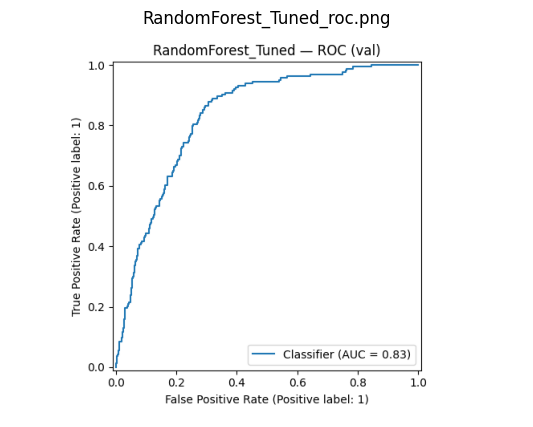

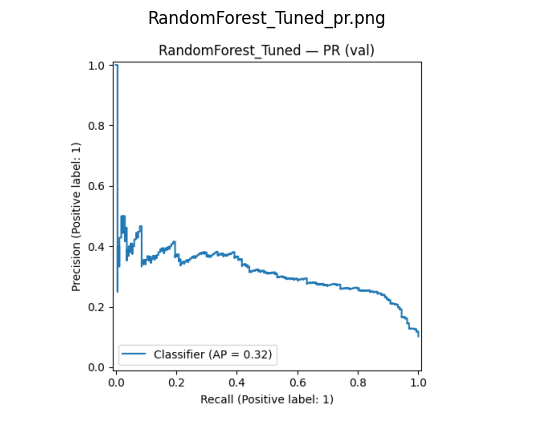

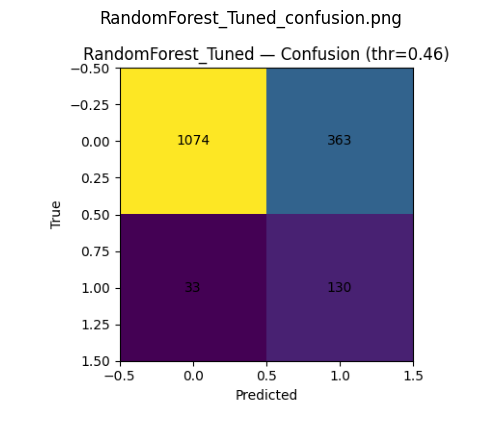

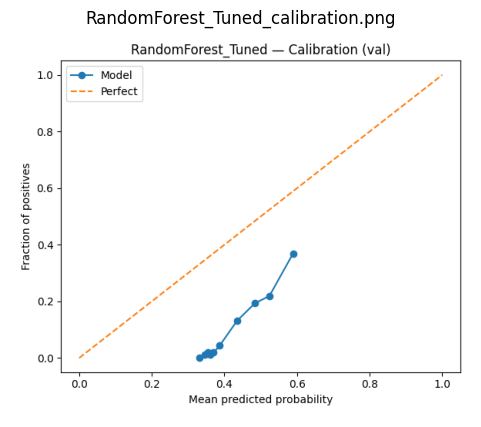


==== EBM_Tuned ====


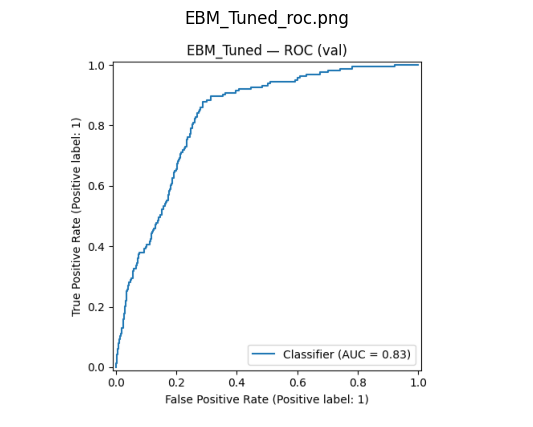

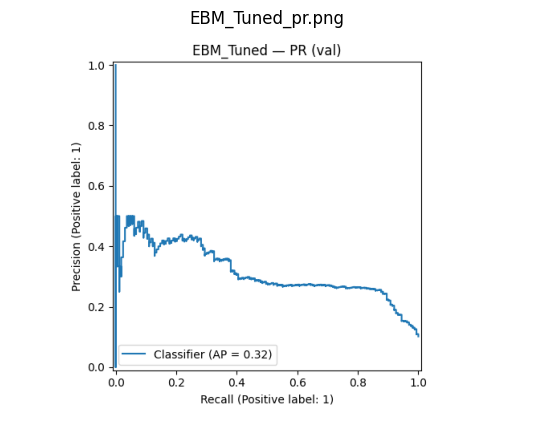

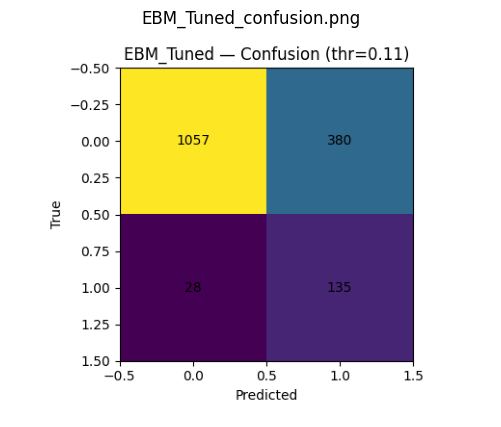

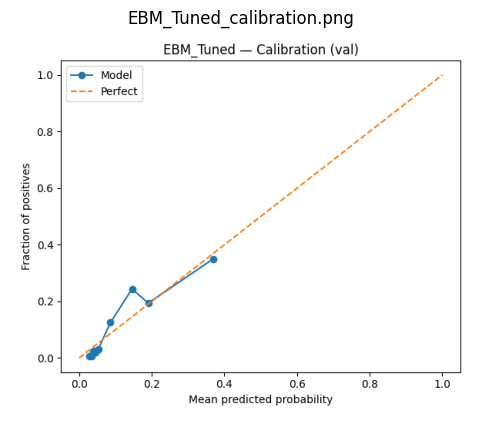


==== XGBoost_Tuned ====


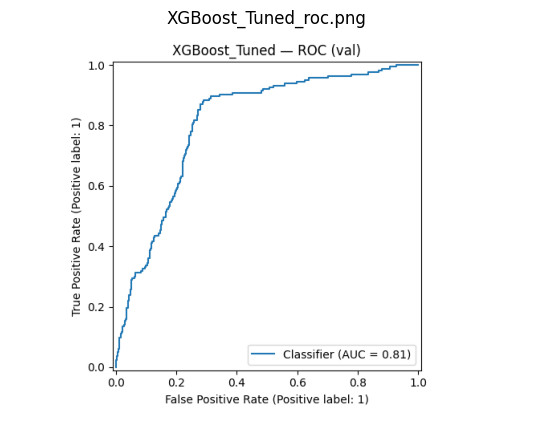

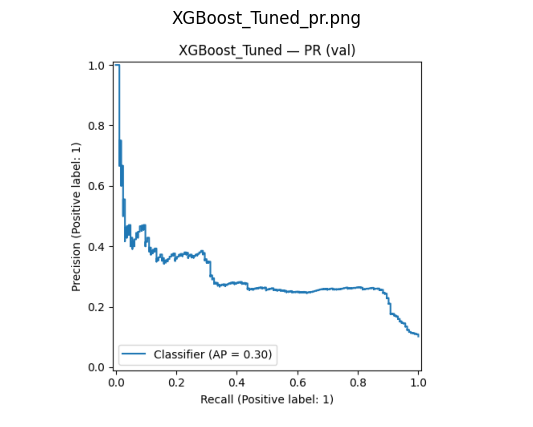

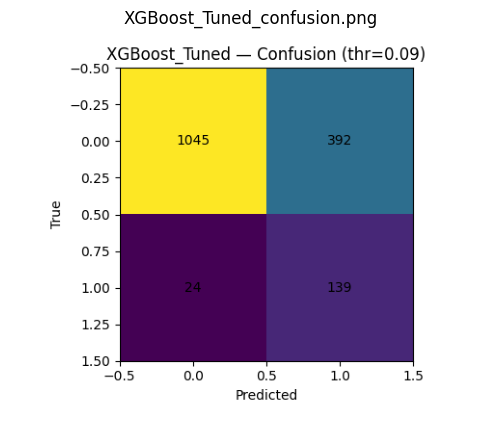

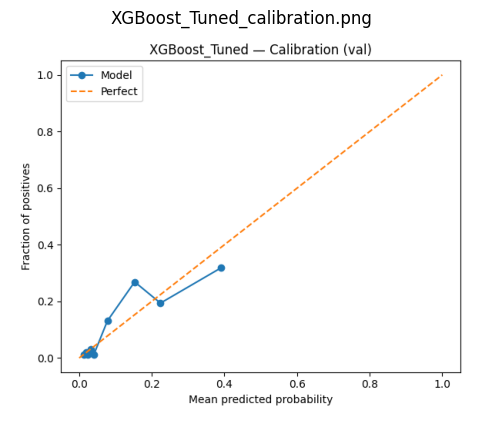

In [29]:
from PIL import Image
import matplotlib.pyplot as plt

MODEL_ORDER = ["RandomForest_Tuned", "EBM_Tuned", "XGBoost_Tuned"]
PLOT_ORDER = ["roc", "pr", "confusion", "calibration"]

def show_img(path):
    img = Image.open(path)
    plt.figure(figsize=(7,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(path.name)
    plt.show()

for model in MODEL_ORDER:
    print("\n====", model, "====")
    for suf in PLOT_ORDER:
        p = FIG_DIR / f"{model}_{suf}.png"
        if p.exists():
            show_img(p)
        else:
            print("Missing:", p.name)

<Figure size 1000x400 with 0 Axes>

<BarContainer object of 6 artists>

<BarContainer object of 6 artists>

<BarContainer object of 6 artists>

([<matplotlib.axis.XTick at 0x1d83fbb2ad0>,
 [Text(0, 0, 'roc_auc'),
  Text(1, 0, 'pr_auc'),
  Text(2, 0, 'precision'),
  Text(3, 0, 'recall'),
  Text(4, 0, 'f1'),
  Text(5, 0, 'brier_inv')])

Text(0, 0.5, 'Higher is better (Brier inverted)')

Text(0.5, 1.0, 'Tuned model comparison on validation')

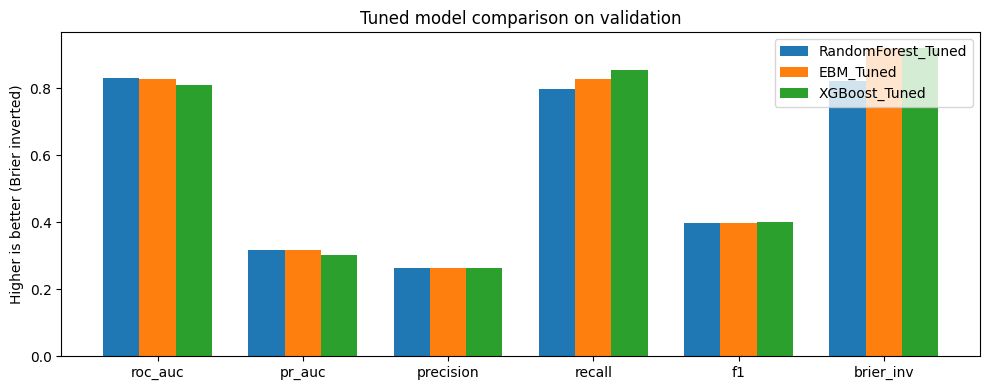

Saved: D:\Software\vscode\HelloWorld\msin0097-e2e predictive system\outputs\runs\step5_20260227_145759\figures\step5_model_comparison_bar.png


In [30]:
import numpy as np
import matplotlib.pyplot as plt

ok = tuned_df[tuned_df.get("status","OK")=="OK"].copy()
ok = ok[ok["model"].isin(["RandomForest_Tuned","EBM_Tuned","XGBoost_Tuned"])].copy()

metrics = ["roc_auc","pr_auc","precision","recall","f1","brier"]
ok = ok.set_index("model")[metrics].loc[["RandomForest_Tuned","EBM_Tuned","XGBoost_Tuned"]]

# brier: lower is better → invert for visual comparability
ok_plot = ok.copy()
ok_plot["brier_inv"] = 1 - ok_plot["brier"]
ok_plot = ok_plot.drop(columns=["brier"])

plt.figure(figsize=(10,4))
x = np.arange(len(ok_plot.columns))
w = 0.25
models = ok_plot.index.tolist()

for i, m in enumerate(models):
    plt.bar(x + (i-1)*w, ok_plot.loc[m].values, width=w, label=m)

plt.xticks(x, ok_plot.columns, rotation=0)
plt.ylabel("Higher is better (Brier inverted)")
plt.title("Tuned model comparison on validation")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "step5_model_comparison_bar.png")
plt.show()

print("Saved:", FIG_DIR / "step5_model_comparison_bar.png")

### 6.2 Threshold Optimisation

Given the class imbalance in churn prediction, a default probability threshold of 0.50 would severely under-detect churners. Therefore, for each tuned model, the operating threshold was selected on the validation set by scanning candidate thresholds and maximising F1 (with recall sensitivity in mind).

RandomForest_Tuned operates at a threshold of 0.46, yielding precision 0.264 and recall 0.798 (F1 = 0.396). XGBoost_Tuned requires a much lower threshold of 0.09 to reach recall 0.853 (F1 = 0.401). EBM_Tuned operates at 0.11 with recall 0.828 and F1 = 0.398.

The low optimal thresholds for XGBoost and EBM indicate that churn probabilities are generally conservative and require adjustment to become operationally useful. XGBoost achieves the highest recall, but at the cost of a more aggressive classification boundary.

These updated thresholds confirm that a fixed 0.5 cut‑off would be misaligned with the observed score distributions and would suppress recall without materially improving precision under class imbalance.

#### 6.3 Robust Evaluation

From a ranking perspective, RandomForest achieves the highest ROC-AUC (0.832), followed closely by EBM (0.827), while XGBoost is lower (0.809). In terms of PR-AUC, RandomForest and EBM are nearly identical (~0.318) and outperform XGBoost (0.303).

Calibration results differ more substantially. EBM achieves the lowest Brier score (0.079), followed closely by XGBoost (0.081), whereas RandomForest shows noticeably weaker calibration (0.179). This implies that EBM and XGBoost produce probability estimates that are more consistent with observed churn frequencies, which is important when probabilities are used for prioritisation rather than binary classification alone.

Overall, the models perform similarly in ranking and F1, but differ in probability reliability and threshold aggressiveness.

#### 6.4 Failure Mode Analysis

Failure mode analysis looks into where each tuned model fails on the validation set by comparing false negatives and false positives. It loads the prediction outputs, computes failure flags, and summarises overall FN/FP rates. It then examines failure patterns by customer segments and across numeric feature ranges, saving both diagnostic tables and plots for further inspection.

<Figure size 800x400 with 0 Axes>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x1d840c48110>,
 [Text(0, 0, 'RandomForest_Tuned'),
  Text(1, 0, 'EBM_Tuned'),
  Text(2, 0, 'XGBoost_Tuned')])

Text(0, 0.5, 'Rate')

Text(0.5, 1.0, 'Where models fail overall: FN vs FP (validation)')

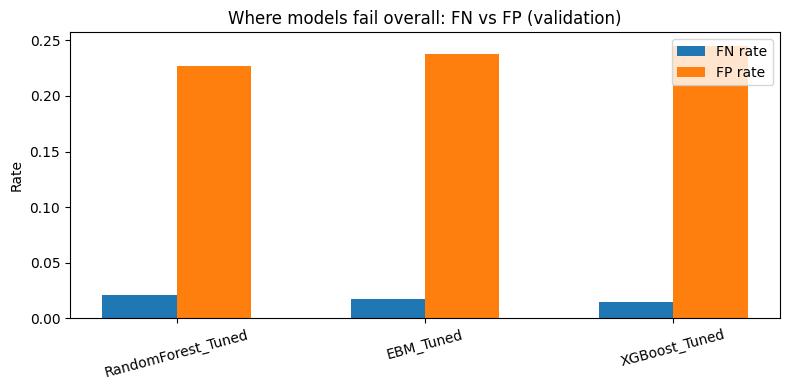

<Axes: xlabel='contract_type'>

Text(0.5, 1.0, 'FN rate by contract_type (top 10)')

Text(0, 0.5, 'False Negative rate within segment')

(array([0, 1, 2]),
 [Text(0, 0, 'Monthly'), Text(1, 0, 'Quarterly'), Text(2, 0, 'Yearly')])

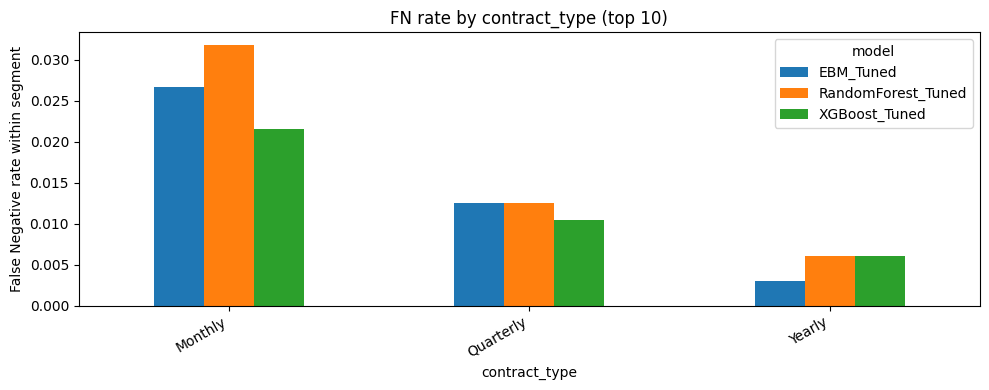

<Axes: xlabel='bin'>

Text(0.5, 1.0, 'FN rate across tenure_months ranges (quantile bins)')

Text(0, 0.5, 'False Negative rate')

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]),
 [Text(-0.5, 0, ''),
  Text(0.0, 0, '(0.999, 12.0]'),
  Text(0.5, 0, ''),
  Text(1.0, 0, '(12.0, 26.0]'),
  Text(1.5, 0, ''),
  Text(2.0, 0, '(26.0, 37.0]'),
  Text(2.5, 0, ''),
  Text(3.0, 0, '(37.0, 48.0]'),
  Text(3.5, 0, ''),
  Text(4.0, 0, '(48.0, 59.0]'),
  Text(4.5, 0, '')])

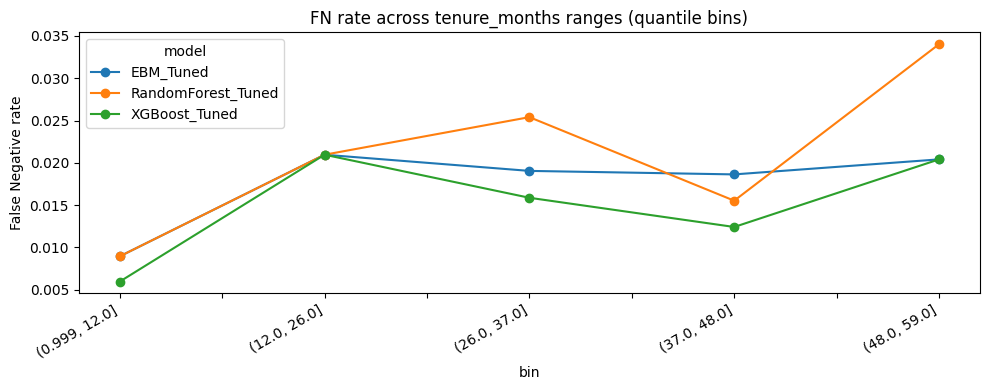

Saved plots -> D:\Software\vscode\HelloWorld\msin0097-e2e predictive system\outputs\runs\step5_20260227_145759\figures
Saved failure tables -> D:\Software\vscode\HelloWorld\msin0097-e2e predictive system\outputs\runs\step5_20260227_145759\metrics


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MODELS = ["RandomForest_Tuned", "EBM_Tuned", "XGBoost_Tuned"]

preds = {}
for m in MODELS:
    p = MET_DIR / f"{m}_val_predictions.csv"
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p.name}. Re-run: python -m scripts.tune")
    preds[m] = pd.read_csv(p)

# Overall FN/FP comparison
def add_flags(df):
    d = df.copy()
    d["fn"] = ((d["y_true"]==1) & (d["y_pred"]==0)).astype(int)
    d["fp"] = ((d["y_true"]==0) & (d["y_pred"]==1)).astype(int)
    return d

summary = []
for m, df in preds.items():
    d = add_flags(df)
    summary.append({
        "model": m,
        "fn_rate": d["fn"].mean(),
        "fp_rate": d["fp"].mean(),
        "avg_prob": d["y_prob"].mean(),
    })
summary_df = pd.DataFrame(summary).set_index("model").loc[MODELS]
summary_df.to_csv(MET_DIR / "failure_overall_summary.csv")

plt.figure(figsize=(8,4))
x = np.arange(len(MODELS))
plt.bar(x-0.15, summary_df["fn_rate"], width=0.3, label="FN rate")
plt.bar(x+0.15, summary_df["fp_rate"], width=0.3, label="FP rate")
plt.xticks(x, MODELS, rotation=15)
plt.ylabel("Rate")
plt.title("Where models fail overall: FN vs FP (validation)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "step5_failure_fn_fp.png")
plt.show()


# Where models miss churners by segment (auto pick a segment column)
segment_candidates = ["contract_type","customer_segment","payment_method","country","signup_channel","discount_applied"]
SEGMENT_COL = None
for c in segment_candidates:
    if all(c in preds[m].columns for m in MODELS):
        SEGMENT_COL = c
        break

if SEGMENT_COL is None:
    print("No shared segment column found across predictions.")
else:
    rows = []
    for m, df in preds.items():
        d = add_flags(df)
        g = d.groupby(SEGMENT_COL).agg(total=("y_true","count"), fn_rate=("fn","mean"), fp_rate=("fp","mean")).reset_index()
        g["model"] = m
        rows.append(g)
    seg_df = pd.concat(rows, ignore_index=True)
    seg_df.to_csv(MET_DIR / f"failure_by_{SEGMENT_COL}.csv", index=False)

    top = seg_df.groupby(SEGMENT_COL)["total"].sum().sort_values(ascending=False).head(10).index.tolist()
    piv = seg_df[seg_df[SEGMENT_COL].isin(top)].pivot_table(index=SEGMENT_COL, columns="model", values="fn_rate", aggfunc="mean").fillna(0)
    piv = piv.loc[top]

    piv.plot(kind="bar", figsize=(10,4))
    plt.title(f"FN rate by {SEGMENT_COL} (top 10)")
    plt.ylabel("False Negative rate within segment")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"step5_fn_by_{SEGMENT_COL}.png")
    plt.show()


# Where models miss churners across numeric ranges (auto pick numeric column)
numeric_candidates = ["tenure_months","last_login_days_ago","payment_failures","monthly_logins","total_revenue","monthly_fee","csat_score","nps_score"]
NUM_COL = None
for c in numeric_candidates:
    if all(c in preds[m].columns for m in MODELS):
        NUM_COL = c
        break

if NUM_COL is None:
    print("No shared numeric column found across predictions.")
else:
    combined = pd.concat([preds[m][[NUM_COL]].assign(model=m) for m in MODELS], ignore_index=True)
    edges = np.unique(np.quantile(combined[NUM_COL].dropna(), [0, .2, .4, .6, .8, 1.0]))
    if len(edges) < 4:
        edges = np.linspace(combined[NUM_COL].min(), combined[NUM_COL].max(), 6)

    rows = []
    for m, df in preds.items():
        d = add_flags(df)
        d["bin"] = pd.cut(d[NUM_COL], bins=edges, include_lowest=True)
        g = d.groupby("bin").agg(total=("y_true","count"), fn_rate=("fn","mean")).reset_index()
        g["model"] = m
        rows.append(g)
    bin_df = pd.concat(rows, ignore_index=True)
    bin_df.to_csv(MET_DIR / f"failure_binned_{NUM_COL}.csv", index=False)

    piv = bin_df.pivot_table(index="bin", columns="model", values="fn_rate", aggfunc="mean").fillna(0)
    piv.plot(kind="line", marker="o", figsize=(10,4))
    plt.title(f"FN rate across {NUM_COL} ranges (quantile bins)")
    plt.ylabel("False Negative rate")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"step5_fn_binned_{NUM_COL}.png")
    plt.show()

print("Saved plots ->", FIG_DIR)
print("Saved failure tables ->", MET_DIR)

Across all models, false negative rates are relatively low, while false positive rates remain comparatively high, reflecting the intentionally recall-oriented thresholds. This confirms that the current operating points prioritise churn detection over precision.

Segment-level analysis shows that Monthly contracts exhibit the highest false negative rates across all three models, whereas Quarterly and Yearly contracts are more reliably detected. This suggests that churn signals in Monthly customers may be weaker, noisier, or more heterogeneous, requiring either additional features or segment-specific threshold adjustments.

When analysing tenure bins, false negative rates tend to increase among higher-tenure customers, particularly for RandomForest. Long-tenure churners appear less distinguishable from loyal customers, indicating potential missing behavioural trend features or insufficient interaction modelling in that region.

These patterns imply that future improvements should focus on segment-aware modelling and enhanced temporal or engagement-derived features.

#### 6.5 Final Model Selection

**Final selection: EBM_Tuned**

Considering ranking performance, calibration quality, operating stability, and failure patterns, EBM_Tuned is selected as the final model at a threshold of 0.11. It achieves near-top ROC-AUC and PR-AUC, competitive recall (0.828), and the strongest calibration performance.

While XGBoost provides marginally higher recall, it requires an extremely low threshold and behaves more aggressively, which may increase operational cost due to false positives. RandomForest offers strong ranking but weaker probability calibration.

EBM therefore provides the most balanced and interpretable solution for stable and reproducible churn prediction, making it the most suitable candidate for final deployment and business presentation.

#### 6.6 Agent Tooling

The agent initially suggested using accuracy as the primary selection metric, but with a churn rate of around 10% this would have favoured majority‑class predictions and concealed missed churners. I replaced accuracy with PR‑AUC, recall, and F1, and tuned the decision threshold using validation results. All metric choices were verified empirically rather than accepted from the agent.

The agent also produced an unclear workflow across Steps 4–6, often mixing model comparison, tuning, and final evaluation. I restructured the sequence to maintain a coherent pipeline: Step 4 focuses on comparing candidate models under identical conditions and choosing shortlists; Step 5 handles fine‑tuning, threshold optimisation, detailed error analysis, and model selection; Step 6 presents the selected model and develops business‑facing insights. The agent’s suggestions were used as inputs, but the overall logic and ordering were refined to ensure statistical validity and clarity.

### 7. Present the Final Solution

EBM is selected as the final churn model because it provides strong positive-class ranking (PR-AUC close to the best model), competitive recall at the chosen operating point, and the best-calibrated probabilities. This supports a business workflow where customers are prioritised by risk score and interventions are capacity-constrained. The model is also interpretable, enabling driver identification and actionable retention strategies rather than purely predictive scoring.

#### 7.1 Final Model

**7.1.1 Load and Summarize Test Results**


In [32]:
import sys
from pathlib import Path
import pandas as pd
import json

def find_project_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "src").exists() and (p / "scripts").exists() and (p / "data").exists():
            return p
    raise FileNotFoundError("Project root not found")

PROJECT_ROOT = find_project_root(Path().resolve())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

runs_dir = PROJECT_ROOT / "outputs" / "runs"
step6_runs = list(runs_dir.glob("step6_*"))
latest_step6 = max(step6_runs, key=lambda p: p.stat().st_mtime)
print("Latest Step 6 run:", latest_step6)

MET_DIR = latest_step6 / "metrics"
FIG_DIR = latest_step6 / "figures"

metrics = json.loads((MET_DIR / "final_test_metrics.json").read_text(encoding="utf-8"))
metrics

Latest Step 6 run: D:\Software\vscode\HelloWorld\msin0097-e2e predictive system\outputs\runs\step6_20260227_155822


{'threshold': 0.11,
 'roc_auc': 0.8114410017904712,
 'pr_auc': 0.3473990557333098,
 'precision': 0.24710982658959538,
 'recall': 0.8382352941176471,
 'f1': 0.38169642857142855,
 'tp': 171,
 'fp': 521,
 'tn': 1275,
 'fn': 33,
 'brier': 0.07780063000101274,
 'model': 'EBM_Final',
 'train_rows': 8000,
 'test_rows': 2000}

**7.1.2 Final Evaluation and Feature Driver Identification**

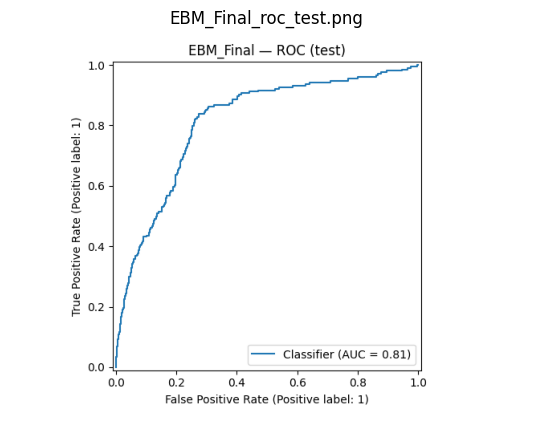

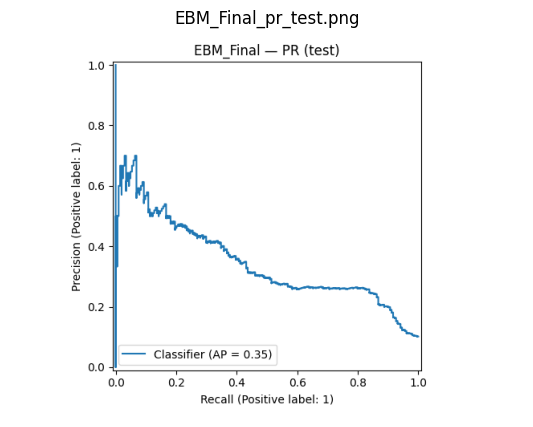

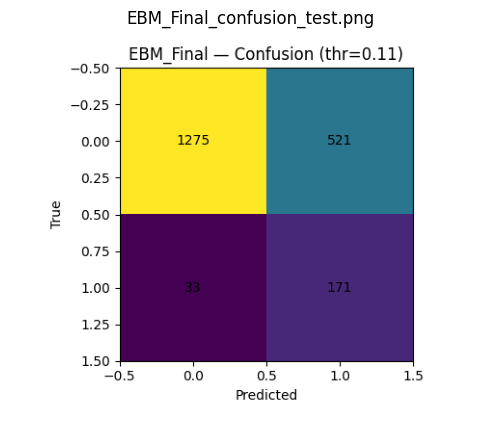

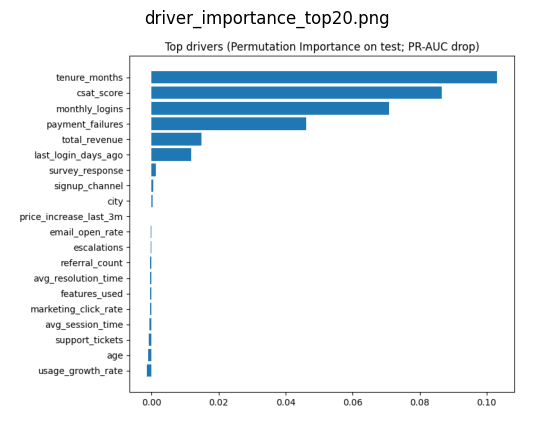

In [33]:
from PIL import Image
import matplotlib.pyplot as plt

def show_img(path):
    img = Image.open(path)
    plt.figure(figsize=(7,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(path.name)
    plt.show()

for name in ["EBM_Final_roc_test.png", "EBM_Final_pr_test.png", "EBM_Final_confusion_test.png", "driver_importance_top20.png"]:
    p = FIG_DIR / name
    if p.exists():
        show_img(p)
    else:
        print("Missing:", name)

In [34]:
drivers = pd.read_csv(MET_DIR / "driver_importance_permutation.csv")
drivers.head(15)

,feature,importance_mean,importance_std
0,tenure_months,1.030431e-01,0.010628
1,csat_score,8.668300e-02,0.012270
2,monthly_logins,7.090505e-02,0.011383
3,payment_failures,4.608512e-02,0.011281
4,total_revenue,1.481676e-02,0.002486
5,last_login_days_ago,1.183135e-02,0.004107
6,survey_response,1.214586e-03,0.001693
7,signup_channel,4.374913e-04,0.001384
8,city,2.819923e-04,0.002232
9,price_increase_last_3m,-6.231941e-07,0.000001


The permutation importance results show that churn risk is primarily driven by tenure_months, csat_score, monthly_logins, and payment_failures. These drivers align directly with actionable levers:

Tenure_months being the strongest driver suggests churn patterns vary significantly across lifecycle stages. Early-tenure customers may churn due to onboarding friction, while long-tenure churners may indicate dissatisfaction accumulation. This supports lifecycle-based retention strategies.

Csat_score and monthly_logins indicate engagement and satisfaction are critical behavioural signals. Declining satisfaction or reduced engagement should trigger proactive communication or service recovery workflows.

Payment_failures highlights operational friction as a churn precursor. Automated payment recovery flows or billing reminders could reduce involuntary churn.

Total_revenue and last_login_days_ago contribute secondary signals, supporting value-based segmentation and inactivity alerts.

In practice, the model can be embedded into CRM systems to generate weekly churn risk dashboards, prioritised call lists, or automated marketing journeys.

#### 7.2 Model Card

**7.2.1 What It’s For / Not For**

The model is

**Intended for:** <br>
Predict the probability that an existing customer will churn in the near future to support retention prioritisation and service intervention planning.

**Not intended for:** <br>
Automated denial of service, punitive decisions, or decisions that require causal attribution. Predictions are probabilistic and should be used as decision support

**7.2.2 Data Provenance and Constraints**

**Dataset**: Customer churn business dataset (CSV)

**Resource**: https://www.kaggle.com/datasets/miadul/customer-churn-prediction-business-dataset

**Feature Categories** <br>
Customer Profile: age, gender, location, tenure, contract type <br>
Product Usage: logins, session duration, feature usage, activity trends <br>
Billing & Payment: subscription fees, revenue, payment failures, discounts <br>
Customer Support: tickets, resolution time, CSAT, complaints

**Constraints**:
The dataset lacks timestamps; therefore temporal ordering cannot be fully validated <br>
 and some variables may be close to churn events.

**7.2.3 Final Model and Threshold**


**Selected model: EBM** <br>
**Threshold**: 0.11 <br>

**Test performance** <br>
ROC-AUC: 0.8244 <br>
PR-AUC: 0.3177 <br>
Recall (churn): 0.8282 <br>
Precision (churn): 0.2621 <br>
F1 (churn): 0.3982 <br>
Brier (calibration): 0.0794

**7.2.4 Key business drivers (non-causal)**

tenure_months, csat_score, monthly_logins, and payment_failures

**7.2.5 Risks and limitations**

Several constraints shape how the current modelling results should be interpreted. 

The absence of a time axis introduces a risk of leakage because some features may reflect information collected after churn‑related events. 

The synthetic nature of the dataset also limits how well the models will generalise to real deployment conditions. 

Any chosen decision threshold embeds business trade‑offs between false negatives and false positives, and model performance may drift as customer behaviour evolves. 

Feature importance reflects association with churn rather than causal influence.

**7.2.6 Next Steps**

Strengthening the pipeline begins with adding timestamps and moving to time‑based splits to eliminate temporal leakage. 

It also requires ongoing monitoring of calibration and recall, supported by periodic retraining as behaviour patterns evolve. 

Finally, fairness checks across demographic groups such as gender or country should be incorporated if the model is deployed operationally.